In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import sys
sys.path.append('../code')
import dataframe_utilities as util

In [4]:
import category_encoders as ce
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials
from functools import partial

import seaborn as sns

# Get Data

In [5]:
df = pd.read_csv('../data/df_w_features.csv', low_memory=False)
df.shape

(24160, 599)

In [6]:
X = df.drop(columns=['home_team_win', 'game_id'])
y = df.home_team_win

In [7]:
mask = pd.to_datetime(X['date'],unit='s')>=pd.to_datetime('20-08-2019') #last time model was run
new_len = mask.sum() + 300 #add 300 more records to include old validation data, but none of the training data

X_train = X[:-new_len]
y_train = y[:-new_len]
X_valid = X[-new_len:]
y_valid = y[-new_len:]

# Benchmark

In [8]:
import pickle
encoder, model = pickle.load(open('../data/encoder_model.pk','rb'))
encoder, model

(CatBoostEncoder(cols=['home_team_abbr', 'away_team_abbr', 'home_pitcher',
                       'away_pitcher', 'home_team_season', 'away_team_season'],
                 drop_invariant=False, handle_missing='value',
                 handle_unknown='value', random_state=13, return_df=True,
                 sigma=None, verbose=0),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=None, colsample_bytree=0.65, gamma=0,
               learning_rate=0.3, max_delta_step=0, max_depth=26,
               min_child_weight=18.0, missing=nan, n_estimators=100, n_jobs=1,
               nthread=None, num_boost_round=100, objective='binary:logistic',
               random_state=13, reg_alpha=0.057490000000000006, reg_lambda=1,
               scale_pos_weight=1, seed=None, silent=True,
               subsample=0.6000000000000001, verbosity=None))

In [9]:
X_train = encoder.fit_transform(X_train, y_train)
X_valid = encoder.transform(X_valid)

In [10]:
xgb_test_preds = model.predict(X_valid)
xgb_test_proba = model.predict_proba(X_valid)[:,1]

bench_acc = accuracy_score(y_valid, xgb_test_preds)
bench_roc = roc_auc_score(y_valid, xgb_test_preds)
print(f"benchmarks:\n- Accuracy: {bench_acc*100:.1f}%\n- ROC AUC: {bench_roc:.3f}")

benchmarks:
- Accuracy: 64.6%
- ROC AUC: 0.637


# XGB

## Tune

In [11]:
from ray import tune
from ray.tune.suggest.bayesopt import BayesOptSearch
def XGBCallback(env):
    tune.track.log(**dict(env.evaluation_result_list))

In [12]:
def train_xgb(params):
    for i in range(10):
        params['max_depth'] = int(params['max_depth'])
        gbm = xgb.XGBClassifier(**params, num_boost_round=100, random_state=13, n_jobs=-1)
        model = gbm.fit(X_train, y_train,
                        verbose=False,
                        eval_set = [[X_train, y_train],
                                  [X_valid, y_valid]],
                        early_stopping_rounds=15)
        xgb_test_preds = model.predict(X_valid)
        proba = model.predict_proba(X_valid)[:,1]

        #penalize low discrimination
        score = roc_auc_score(y_valid, xgb_test_preds)
        if max(proba)<.7 and min(proba)>.3: score -= 0.05

        tune.track.log(mean_accuracy=score, done=True)

In [13]:
num_threads = 6
config = {
    "verbosity": 0,
    "num_threads": num_threads,
    "objective": "binary:logistic",
    "eval_metric": ["auc", "logloss"],
}

from ray.tune.schedulers import ASHAScheduler

#     "max_depth": tune.randint(10, 20),
#     "min_child_weight": tune.randint(2, 10),
#     "learning_rate": tune.uniform(0.01,0.1),
#     "subsample":tune.uniform(0.1,1),
#     "colsample_bytree":tune.uniform(0.1,1),
#     "reg_alpha": tune.uniform(1e-2, 1e2),
#     "gamma": tune.uniform(1e-8, 1.0),


space = {
#     "verbosity": 0,
#     "num_threads": (6,6),
#     "objective": "binary:logistic",
#     "eval_metric": ["auc", "logloss"],
    "max_depth": (10, 20),
    "min_child_weight": (2, 10),
    "learning_rate": (0.01,0.1),
    "subsample":(0.1,1),
    "colsample_bytree":(0.1,1),
    "reg_alpha": (1e-2, 1e2),
    "gamma": (1e-8, 1.0),
}

algo = BayesOptSearch(
    space,
    max_concurrent=4,
    metric="mean_accuracy",
    mode="max",
    utility_kwargs={
            "kind": "ucb",
            "kappa": 2.5,
            "xi": 0.0,
        },
)

results = tune.run(
    train_xgb,
    num_samples=500,
    search_alg=algo,
    scheduler=ASHAScheduler(metric="eval-logloss", mode="min"),
)

2019-08-27 12:32:58,882	WARNING worker.py:1438 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-08-27 12:32:58,884	INFO resource_spec.py:205 -- Starting Ray with 5.86 GiB memory available for workers and up to 2.95 GiB for objects. You can adjust these settings with ray.remote(memory=<bytes>, object_store_memory=<bytes>).
2019-08-27 12:32:59,473	INFO function_runner.py:254 -- tune.track signature detected.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 3.9/15.4 GiB



2019-08-27 12:33:02,027	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:33:02,027	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:33:02,147	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 4.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 4 ({'RUNNING': 1, 'PENDING': 3})
PENDING trials:
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_child_weight=7.4818,reg_alpha=20.453,subsample=0.89031:	PENDING
 - train_xgb_3_colsample_bytree=0.12465,gamma=0.67047,learning_rate=0.047557,max_depth=15.587,min_child_weight=3.1231,reg_alpha=19.818,subsample=0.82067:	PENDING
 - train_xgb_4_colsample_bytree=0.97144,gamma=0.31342,learning_rate=0.072309,max_depth=18.764,min_child_weight=9.1569,reg_alpha=8.5136,subsample=0.13515:	PENDING
RUNNING trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.

2019-08-27 12:33:02,733	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:33:02,734	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:33:02,868	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:33:03,247	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:33:03,248	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:33:03,390	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:33:03,740	WARNING logger.py:164 -- C

Result for train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_child_weight=7.4818,reg_alpha=20.453,subsample=0.89031:
  date: 2019-08-27_12-33-45
  done: true
  experiment_id: ed9e67710d5c4c5e9fa52772e2278aff
  hostname: system76-pc
  iterations_since_restore: 1
  mean_accuracy: 0.5434915977594024
  node_ip: 10.6.11.6
  pid: 13966
  time_since_restore: 41.37108325958252
  time_this_iter_s: 41.37108325958252
  time_total_s: 41.37108325958252
  timestamp: 1566934425
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 7af7f910
  
== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 3/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 4 ({'RUNNING': 3, 'TERMINATED': 1})
RUNNING trials:
 - train_xgb_1_colsample_bytree=0.475

2019-08-27 12:33:49,451	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:33:49,452	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:33:49,661	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


Result for train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:
  date: 2019-08-27_12-33-46
  done: true
  experiment_id: 81dd4e7d1ef64506b763291bbeef6617
  hostname: system76-pc
  iterations_since_restore: 1
  mean_accuracy: 0.5481298716694821
  node_ip: 10.6.11.6
  pid: 13970
  time_since_restore: 43.06595706939697
  time_this_iter_s: 43.06595706939697
  time_total_s: 43.06595706939697
  timestamp: 1566934426
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 7aaf68c6
  


2019-08-27 12:34:07,800	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:34:07,804	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:34:08,101	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:34:08,216	WARNING util.py:144 -- The `start_trial` operation took 0.9463770389556885 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 6 ({'TERMINATED': 2, 'RUNNING': 4})
RUNNING trials:
 - train_xgb_3_colsample_bytree=0.12465,gamma=0.67047,learning_rate=0.047557,max_depth=15.587,min_child_weight=3.1231,reg_alpha=19.818,subsample=0.82067:	RUNNING
 - train_xgb_4_colsample_bytree=0.97144,gamma=0.31342,learning_rate=0.072309,max_depth=18.764,min_child_weight=9.1569,reg_alpha=8.5136,subsample=0.13515:	RUNNING
 - train_xgb_5_colsample_bytree=0.25365,gamma=0.72002,learning_rate=0.010085,max_depth=16.949,min_child_weight=7.508,reg_alpha=56.882,subsample=0.32669:	RUNNING
 - train_xgb_6_colsample_bytree=0.6014,gamma=0.20257,learning_rate=0.059189,max_depth=19.736,min_child_weight=9.8994,reg_alpha=0.62719,subsa

2019-08-27 12:34:26,331	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:34:26,332	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:34:26,641	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:34:26,739	WARNING util.py:144 -- The `start_trial` operation took 0.8777930736541748 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 7 ({'TERMINATED': 3, 'RUNNING': 4})
RUNNING trials:
 - train_xgb_4_colsample_bytree=0.97144,gamma=0.31342,learning_rate=0.072309,max_depth=18.764,min_child_weight=9.1569,reg_alpha=8.5136,subsample=0.13515:	RUNNING
 - train_xgb_5_colsample_bytree=0.25365,gamma=0.72002,learning_rate=0.010085,max_depth=16.949,min_child_weight=7.508,reg_alpha=56.882,subsample=0.32669:	RUNNING
 - train_xgb_6_colsample_bytree=0.6014,gamma=0.20257,learning_rate=0.059189,max_depth=19.736,min_child_weight=9.8994,reg_alpha=0.62719,subsample=0.93539:	RUNNING
 - train_xgb_7_colsample_bytree=0.5576,gamma=0.37387,learning_rate=0.012949,max_depth=19.422,min_child_weight=9.945,reg_alpha=0.13849,subsam

2019-08-27 12:34:54,472	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:34:54,473	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:34:54,600	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:34:54,662	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 8 ({'TERMINATED': 4, 'RUNNING': 4})
RUNNING trials:
 - train_xgb_4_colsample_bytree=0.97144,gamma=0.31342,learning_rate=0.072309,max_depth=18.764,min_child_weight=9.1569,reg_alpha=8.5136,subsample=0.13515:	RUNNING
 - train_xgb_6_colsample_bytree=0.6014,gamma=0.20257,learning_rate=0.059189,max_depth=19.736,min_child_weight=9.8994,reg_alpha=0.62719,subsample=0.93539:	RUNNING
 - train_xgb_7_colsample_bytree=0.5576,gamma=0.37387,learning_rate=0.012949,max_depth=19.422,min_child_weight=9.945,reg_alpha=0.13849,subsample=0.26586:	RUNNING
 - train_xgb_8_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING

2019-08-27 12:35:09,999	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:35:10,001	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:35:10,399	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:35:10,502	WARNING util.py:144 -- The `start_trial` operation took 1.0108616352081299 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 5.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 9 ({'TERMINATED': 5, 'RUNNING': 4})
RUNNING trials:
 - train_xgb_4_colsample_bytree=0.97144,gamma=0.31342,learning_rate=0.072309,max_depth=18.764,min_child_weight=9.1569,reg_alpha=8.5136,subsample=0.13515:	RUNNING
 - train_xgb_6_colsample_bytree=0.6014,gamma=0.20257,learning_rate=0.059189,max_depth=19.736,min_child_weight=9.8994,reg_alpha=0.62719,subsample=0.93539:	RUNNING
 - train_xgb_8_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_9_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING
TERMINATED trials:

2019-08-27 12:35:27,435	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:35:27,436	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:35:27,715	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:35:27,824	WARNING util.py:144 -- The `start_trial` operation took 1.1434733867645264 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 10 ({'TERMINATED': 6, 'RUNNING': 4})
RUNNING trials:
 - train_xgb_6_colsample_bytree=0.6014,gamma=0.20257,learning_rate=0.059189,max_depth=19.736,min_child_weight=9.8994,reg_alpha=0.62719,subsample=0.93539:	RUNNING
 - train_xgb_8_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_9_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_10_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=19.418,min_child_weight=10.0,reg_alpha=100.0,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_co

2019-08-27 12:35:54,219	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:35:54,220	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:35:54,369	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 5.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 11 ({'TERMINATED': 7, 'RUNNING': 4})
RUNNING trials:
 - train_xgb_8_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_9_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_10_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=19.418,min_child_weight=10.0,reg_alpha=100.0,subsample=0.1:	RUNNING
 - train_xgb_11_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.4753

2019-08-27 12:36:06,027	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:36:06,029	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:36:06,149	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:36:06,200	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 12 ({'TERMINATED': 8, 'RUNNING': 4})
RUNNING trials:
 - train_xgb_8_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_9_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_11_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	RUNNING
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,

2019-08-27 12:36:17,418	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:36:17,418	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:36:17,555	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:36:17,616	ERROR trial_runner.py:552 -- Error processing event.
Traceback (most recent call last):
  File "/home/rdpharr/anaconda3/lib/python3.7/site-packages/ray/tune/trial_runner.py", line 516, in _process_trial
    trial.trial_id, result=flat_result)
  File "/home/rdpharr/anaconda3/lib/python3.7/site-packages/ray/tune/suggest/bayesopt.py", line 108, in on_trial_complete
    target=self._metric_op * result[self._metric])
  File "/home/rdpharr/anaconda3/lib/python3.7/site-packages/bayes_opt/bayesian_optimi

== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 13 ({'TERMINATED': 9, 'RUNNING': 4})
RUNNING trials:
 - train_xgb_8_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_9_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	RUNNING
 - train_xgb_13_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=10.0,reg_alpha=78.193,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.4753

2019-08-27 12:36:28,637	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:36:28,637	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:36:28,750	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 14 ({'TERMINATED': 9, 'RUNNING': 4, 'ERROR': 1})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_8_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_9_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.01,max_depth=10.0,

2019-08-27 12:36:39,562	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:36:39,562	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:36:39,701	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 15 ({'TERMINATED': 10, 'RUNNING': 4, 'ERROR': 1})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_8_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_9_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.01,max_depth=10.0

2019-08-27 12:36:52,909	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:36:52,909	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:36:53,025	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 16 ({'TERMINATED': 11, 'RUNNING': 4, 'ERROR': 1})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_8_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_14_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,

2019-08-27 12:37:11,543	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:37:11,543	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:37:11,670	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:37:11,738	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 17 ({'TERMINATED': 12, 'RUNNING': 4, 'ERROR': 1})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_8_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_14_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,

2019-08-27 12:37:27,264	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:37:27,265	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:37:27,385	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 18 ({'TERMINATED': 13, 'RUNNING': 4, 'ERROR': 1})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_8_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_14_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,

2019-08-27 12:37:41,126	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:37:41,126	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:37:41,270	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 19 ({'TERMINATED': 14, 'RUNNING': 4, 'ERROR': 1})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_8_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_17_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.01,max_depth=10.

2019-08-27 12:37:52,697	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:37:52,698	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:37:52,819	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 20 ({'TERMINATED': 15, 'RUNNING': 4, 'ERROR': 1})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_8_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_17_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.01,max_depth=10.

2019-08-27 12:38:04,550	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:38:04,550	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:38:04,676	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 21 ({'TERMINATED': 16, 'RUNNING': 4, 'ERROR': 1})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_8_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_19_colsample_bytree=0.10195,gamma=0.87159,learning_rate=0.082112,max

2019-08-27 12:38:20,374	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:38:20,379	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:38:20,838	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:38:21,082	WARNING util.py:144 -- The `start_trial` operation took 1.2464144229888916 seconds to complete, which may be a performance bottleneck.
2019-08-27 12:38:21,147	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 22 ({'TERMINATED': 17, 'RUNNING': 4, 'ERROR': 1})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_8_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_20_colsample_bytree=0.1029,gamma=0.94068,learning_rate=0.064841,max_

2019-08-27 12:38:42,217	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:38:42,218	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:38:42,636	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:38:42,786	WARNING util.py:144 -- The `start_trial` operation took 1.1088743209838867 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 23 ({'TERMINATED': 18, 'RUNNING': 4, 'ERROR': 1})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_8_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_21_colsample_bytree=0.38041,gamma=0.33334,learning_rate=0.0403,max_d

2019-08-27 12:39:04,065	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:39:04,067	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:39:04,496	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:39:04,643	WARNING util.py:144 -- The `start_trial` operation took 1.250969648361206 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 24 ({'TERMINATED': 19, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_21_colsample_bytree=0.38041,gamma=0.33334,learning_rate=0.0403,max_depth=19.988,min_child_weight=9.7186,reg_alpha=39.589,subsample=0.3371:	RUNNING
 - train_xgb_22_colsample_bytree=0.992,gamma=0.83493,learning_

2019-08-27 12:39:27,329	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:39:27,329	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:39:27,477	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 25 ({'TERMINATED': 20, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_22_colsample_bytree=0.992,gamma=0.83493,learning_rate=0.01622,max_depth=19.971,min_child_weight=2.4835,reg_alpha=40.803,subsample=0.31699:	RUNNING
 - train_xgb_23_colsample_bytree=0.94241,gamma=0.54512,learnin

2019-08-27 12:39:42,633	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:39:42,634	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:39:42,765	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 26 ({'TERMINATED': 21, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_22_colsample_bytree=0.992,gamma=0.83493,learning_rate=0.01622,max_depth=19.971,min_child_weight=2.4835,reg_alpha=40.803,subsample=0.31699:	RUNNING
 - train_xgb_23_colsample_bytree=0.94241,gamma=0.54512,learnin

2019-08-27 12:40:00,136	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:40:00,137	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:40:00,612	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:40:00,761	WARNING util.py:144 -- The `start_trial` operation took 1.266404390335083 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 27 ({'TERMINATED': 22, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_22_colsample_bytree=0.992,gamma=0.83493,learning_rate=0.01622,max_depth=19.971,min_child_weight=2.4835,reg_alpha=40.803,subsample=0.31699:	RUNNING
 - train_xgb_23_colsample_bytree=0.94241,gamma=0.54512,learnin

2019-08-27 12:40:24,470	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:40:24,470	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:40:24,610	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:40:24,673	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 28 ({'TERMINATED': 23, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_23_colsample_bytree=0.94241,gamma=0.54512,learning_rate=0.060175,max_depth=19.916,min_child_weight=2.0828,reg_alpha=44.312,subsample=0.36126:	RUNNING
 - train_xgb_26_colsample_bytree=0.90479,gamma=0.91179,lear

2019-08-27 12:40:37,655	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:40:37,655	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:40:37,794	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 29 ({'TERMINATED': 24, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_23_colsample_bytree=0.94241,gamma=0.54512,learning_rate=0.060175,max_depth=19.916,min_child_weight=2.0828,reg_alpha=44.312,subsample=0.36126:	RUNNING
 - train_xgb_26_colsample_bytree=0.90479,gamma=0.91179,lear

2019-08-27 12:40:58,001	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:40:58,003	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:40:58,278	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:40:58,386	WARNING util.py:144 -- The `start_trial` operation took 0.8775849342346191 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 30 ({'TERMINATED': 25, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_23_colsample_bytree=0.94241,gamma=0.54512,learning_rate=0.060175,max_depth=19.916,min_child_weight=2.0828,reg_alpha=44.312,subsample=0.36126:	RUNNING
 - train_xgb_26_colsample_bytree=0.90479,gamma=0.91179,lear

2019-08-27 12:41:20,549	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:41:20,550	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:41:20,677	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 31 ({'TERMINATED': 26, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_26_colsample_bytree=0.90479,gamma=0.91179,learning_rate=0.08777,max_depth=19.814,min_child_weight=2.0557,reg_alpha=48.999,subsample=0.87049:	RUNNING
 - train_xgb_29_colsample_bytree=0.89903,gamma=0.65967,learn

2019-08-27 12:41:40,267	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:41:40,268	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:41:40,548	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:41:40,633	WARNING util.py:144 -- The `start_trial` operation took 0.8881442546844482 seconds to complete, which may be a performance bottleneck.
2019-08-27 12:41:40,691	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 32 ({'TERMINATED': 27, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_26_colsample_bytree=0.90479,gamma=0.91179,learning_rate=0.08777,max_depth=19.814,min_child_weight=2.0557,reg_alpha=48.999,subsample=0.87049:	RUNNING
 - train_xgb_29_colsample_bytree=0.89903,gamma=0.65967,learn

2019-08-27 12:42:03,561	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:42:03,561	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:42:03,765	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:42:03,809	WARNING util.py:144 -- The `start_trial` operation took 0.5200107097625732 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 5.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 33 ({'TERMINATED': 28, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_26_colsample_bytree=0.90479,gamma=0.91179,learning_rate=0.08777,max_depth=19.814,min_child_weight=2.0557,reg_alpha=48.999,subsample=0.87049:	RUNNING
 - train_xgb_31_colsample_bytree=0.75353,gamma=0.90461,learn

2019-08-27 12:42:23,758	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:42:23,759	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:42:24,083	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:42:24,209	WARNING util.py:144 -- The `start_trial` operation took 1.1017913818359375 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 34 ({'TERMINATED': 29, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_26_colsample_bytree=0.90479,gamma=0.91179,learning_rate=0.08777,max_depth=19.814,min_child_weight=2.0557,reg_alpha=48.999,subsample=0.87049:	RUNNING
 - train_xgb_31_colsample_bytree=0.75353,gamma=0.90461,learn

2019-08-27 12:42:50,670	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:42:50,670	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:42:50,808	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:42:50,871	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 5.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 35 ({'TERMINATED': 30, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_31_colsample_bytree=0.75353,gamma=0.90461,learning_rate=0.082376,max_depth=19.517,min_child_weight=9.8826,reg_alpha=71.085,subsample=0.88713:	RUNNING
 - train_xgb_33_colsample_bytree=0.86543,gamma=0.94294,lear

2019-08-27 12:43:13,528	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:43:13,529	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:43:13,682	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:43:13,741	WARNING util.py:144 -- The `start_trial` operation took 0.5352935791015625 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 36 ({'TERMINATED': 31, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_31_colsample_bytree=0.75353,gamma=0.90461,learning_rate=0.082376,max_depth=19.517,min_child_weight=9.8826,reg_alpha=71.085,subsample=0.88713:	RUNNING
 - train_xgb_33_colsample_bytree=0.86543,gamma=0.94294,lear

2019-08-27 12:43:32,723	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:43:32,724	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:43:33,040	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:43:33,182	WARNING util.py:144 -- The `start_trial` operation took 1.0672423839569092 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 37 ({'TERMINATED': 32, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_33_colsample_bytree=0.86543,gamma=0.94294,learning_rate=0.091154,max_depth=19.502,min_child_weight=2.8118,reg_alpha=99.096,subsample=0.98297:	RUNNING
 - train_xgb_35_colsample_bytree=1.0,gamma=1.0,learning_rat

2019-08-27 12:44:06,952	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:44:06,952	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:44:07,115	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:44:07,177	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 38 ({'TERMINATED': 33, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_35_colsample_bytree=1.0,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.1193,reg_alpha=0.01,subsample=0.1:	RUNNING
 - train_xgb_36_colsample_bytree=0.97992,gamma=0.82423,learning_rate=0.07771,ma

2019-08-27 12:44:17,937	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:44:17,937	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:44:18,073	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 39 ({'TERMINATED': 34, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_35_colsample_bytree=1.0,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.1193,reg_alpha=0.01,subsample=0.1:	RUNNING
 - train_xgb_36_colsample_bytree=0.97992,gamma=0.82423,learning_rate=0.07771,ma

2019-08-27 12:44:35,361	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:44:35,361	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:44:35,507	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 40 ({'TERMINATED': 35, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_35_colsample_bytree=1.0,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.1193,reg_alpha=0.01,subsample=0.1:	RUNNING
 - train_xgb_36_colsample_bytree=0.97992,gamma=0.82423,learning_rate=0.07771,ma

2019-08-27 12:44:47,275	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:44:47,275	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:44:47,419	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 41 ({'TERMINATED': 36, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_36_colsample_bytree=0.97992,gamma=0.82423,learning_rate=0.07771,max_depth=19.817,min_child_weight=9.5428,reg_alpha=86.292,subsample=0.99031:	RUNNING
 - train_xgb_39_colsample_bytree=0.89509,gamma=0.026865,lear

2019-08-27 12:44:59,891	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:44:59,892	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:45:00,017	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 42 ({'TERMINATED': 37, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_39_colsample_bytree=0.89509,gamma=0.026865,learning_rate=0.039304,max_depth=10.095,min_child_weight=9.9027,reg_alpha=51.93,subsample=0.39275:	RUNNING
 - train_xgb_40_colsample_bytree=0.12859,gamma=0.73149,lear

2019-08-27 12:45:20,038	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:45:20,040	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:45:20,481	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:45:20,592	WARNING util.py:144 -- The `start_trial` operation took 1.1149444580078125 seconds to complete, which may be a performance bottleneck.
2019-08-27 12:45:20,682	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 43 ({'TERMINATED': 38, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_40_colsample_bytree=0.12859,gamma=0.73149,learning_rate=0.090379,max_depth=10.231,min_child_weight=9.8393,reg_alpha=97.29,subsample=0.99712:	RUNNING
 - train_xgb_41_colsample_bytree=0.28549,gamma=0.26138,learn

2019-08-27 12:45:43,386	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:45:43,386	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:45:43,503	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 44 ({'TERMINATED': 39, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_40_colsample_bytree=0.12859,gamma=0.73149,learning_rate=0.090379,max_depth=10.231,min_child_weight=9.8393,reg_alpha=97.29,subsample=0.99712:	RUNNING
 - train_xgb_42_colsample_bytree=1.0,gamma=1.0,learning_rate

2019-08-27 12:45:56,219	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:45:56,220	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:45:56,353	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 45 ({'TERMINATED': 40, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_40_colsample_bytree=0.12859,gamma=0.73149,learning_rate=0.090379,max_depth=10.231,min_child_weight=9.8393,reg_alpha=97.29,subsample=0.99712:	RUNNING
 - train_xgb_42_colsample_bytree=1.0,gamma=1.0,learning_rate

2019-08-27 12:46:13,268	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:46:13,269	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:46:13,592	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:46:13,730	WARNING util.py:144 -- The `start_trial` operation took 0.959787130355835 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 46 ({'TERMINATED': 41, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_40_colsample_bytree=0.12859,gamma=0.73149,learning_rate=0.090379,max_depth=10.231,min_child_weight=9.8393,reg_alpha=97.29,subsample=0.99712:	RUNNING
 - train_xgb_42_colsample_bytree=1.0,gamma=1.0,learning_rate

2019-08-27 12:46:33,630	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:46:33,631	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:46:33,775	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:46:33,835	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 47 ({'TERMINATED': 42, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_42_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_45_colsample_bytree=0.68748,gamma=0.4045,learning_rate=0.025101,max_

2019-08-27 12:46:48,732	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:46:48,732	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:46:48,860	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 48 ({'TERMINATED': 43, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_42_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_45_colsample_bytree=0.68748,gamma=0.4045,learning_rate=0.025101,max_

2019-08-27 12:47:06,369	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:47:06,370	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:47:06,756	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:47:06,878	WARNING util.py:144 -- The `start_trial` operation took 1.085641622543335 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 49 ({'TERMINATED': 44, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_42_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=100.0,subsample=1.0:	RUNNING
 - train_xgb_47_colsample_bytree=1.0,gamma=0.97238,learning_rate=0.1,max_depth=10

2019-08-27 12:47:29,067	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:47:29,068	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:47:29,222	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:47:29,277	WARNING util.py:144 -- The `start_trial` operation took 0.5078306198120117 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 50 ({'TERMINATED': 45, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_47_colsample_bytree=1.0,gamma=0.97238,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0214,reg_alpha=26.359,subsample=0.11116:	RUNNING
 - train_xgb_48_colsample_bytree=0.97502,gamma=0.013253,learning_rate=

2019-08-27 12:47:49,059	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:47:49,059	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:47:49,210	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:47:49,284	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 51 ({'TERMINATED': 46, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_48_colsample_bytree=0.97502,gamma=0.013253,learning_rate=0.024547,max_depth=10.084,min_child_weight=2.1103,reg_alpha=66.581,subsample=0.64:	RUNNING
 - train_xgb_49_colsample_bytree=1.0,gamma=1.0,learning_rate=

2019-08-27 12:48:09,400	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:48:09,402	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:48:09,821	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:48:09,921	WARNING util.py:144 -- The `start_trial` operation took 1.0220515727996826 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 52 ({'TERMINATED': 47, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_48_colsample_bytree=0.97502,gamma=0.013253,learning_rate=0.024547,max_depth=10.084,min_child_weight=2.1103,reg_alpha=66.581,subsample=0.64:	RUNNING
 - train_xgb_49_colsample_bytree=1.0,gamma=1.0,learning_rate=

2019-08-27 12:48:33,012	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:48:33,020	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:48:33,512	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:48:33,649	WARNING util.py:144 -- The `start_trial` operation took 1.353830337524414 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 53 ({'TERMINATED': 48, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_49_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=0.1:	RUNNING
 - train_xgb_51_colsample_bytree=1.0,gamma=1.0,learning_rate=0.01,max_depth=20.0,mi

2019-08-27 12:48:50,453	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:48:50,454	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:48:50,581	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:48:50,639	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 54 ({'TERMINATED': 49, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_51_colsample_bytree=1.0,gamma=1.0,learning_rate=0.01,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=0.1:	RUNNING
 - train_xgb_52_colsample_bytree=0.91729,gamma=0.14338,learning_rate=0.044869,max_

2019-08-27 12:49:02,761	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:49:02,762	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:49:02,897	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 55 ({'TERMINATED': 50, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_51_colsample_bytree=1.0,gamma=1.0,learning_rate=0.01,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=0.1:	RUNNING
 - train_xgb_52_colsample_bytree=0.91729,gamma=0.14338,learning_rate=0.044869,max_

2019-08-27 12:49:25,030	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:49:25,031	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:49:25,342	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:49:25,488	WARNING util.py:144 -- The `start_trial` operation took 0.9963603019714355 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 56 ({'TERMINATED': 51, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_51_colsample_bytree=1.0,gamma=1.0,learning_rate=0.01,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=0.1:	RUNNING
 - train_xgb_54_colsample_bytree=0.45395,gamma=0.18393,learning_rate=0.020481,max_

2019-08-27 12:49:51,173	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:49:51,174	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:49:51,546	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:49:51,647	WARNING util.py:144 -- The `start_trial` operation took 0.9211201667785645 seconds to complete, which may be a performance bottleneck.
2019-08-27 12:49:51,694	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 57 ({'TERMINATED': 52, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_51_colsample_bytree=1.0,gamma=1.0,learning_rate=0.01,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=0.1:	RUNNING
 - train_xgb_55_colsample_bytree=0.8875,gamma=0.072967,learning_rate=0.027551,max_

2019-08-27 12:50:30,970	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:50:30,972	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:50:31,592	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:50:31,773	WARNING util.py:144 -- The `start_trial` operation took 1.68184494972229 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 58 ({'TERMINATED': 53, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_51_colsample_bytree=1.0,gamma=1.0,learning_rate=0.01,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=0.1:	RUNNING
 - train_xgb_56_colsample_bytree=1.0,gamma=0.060227,learning_rate=0.1,max_depth=20

2019-08-27 12:51:28,280	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:51:28,281	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:51:28,647	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:51:28,801	WARNING util.py:144 -- The `start_trial` operation took 1.135669231414795 seconds to complete, which may be a performance bottleneck.
2019-08-27 12:51:28,929	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 59 ({'TERMINATED': 54, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_56_colsample_bytree=1.0,gamma=0.060227,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=65.821,subsample=1.0:	RUNNING
 - train_xgb_57_colsample_bytree=0.65773,gamma=0.64998,learning_rate=0.09761

2019-08-27 12:52:13,521	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:52:13,525	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:52:13,990	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:52:14,151	WARNING util.py:144 -- The `start_trial` operation took 1.1006760597229004 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 60 ({'TERMINATED': 55, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_56_colsample_bytree=1.0,gamma=0.060227,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=65.821,subsample=1.0:	RUNNING
 - train_xgb_58_colsample_bytree=0.97918,gamma=0.10722,learning_rate=0.09688

2019-08-27 12:52:48,786	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:52:48,787	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:52:48,924	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:52:48,986	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 61 ({'TERMINATED': 56, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_56_colsample_bytree=1.0,gamma=0.060227,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=65.821,subsample=1.0:	RUNNING
 - train_xgb_59_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth

2019-08-27 12:53:10,637	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:53:10,637	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:53:10,767	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 62 ({'TERMINATED': 57, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_56_colsample_bytree=1.0,gamma=0.060227,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=65.821,subsample=1.0:	RUNNING
 - train_xgb_59_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth

2019-08-27 12:53:23,496	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:53:23,496	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:53:23,622	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 63 ({'TERMINATED': 58, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_56_colsample_bytree=1.0,gamma=0.060227,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=65.821,subsample=1.0:	RUNNING
 - train_xgb_61_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth

2019-08-27 12:53:37,884	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:53:37,885	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:53:37,999	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 64 ({'TERMINATED': 59, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_56_colsample_bytree=1.0,gamma=0.060227,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=65.821,subsample=1.0:	RUNNING
 - train_xgb_61_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth

2019-08-27 12:53:58,608	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:53:58,609	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:53:58,764	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:53:58,823	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 65 ({'TERMINATED': 60, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_56_colsample_bytree=1.0,gamma=0.060227,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=65.821,subsample=1.0:	RUNNING
 - train_xgb_61_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth

2019-08-27 12:54:18,983	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:54:18,983	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:54:19,131	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 66 ({'TERMINATED': 61, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_56_colsample_bytree=1.0,gamma=0.060227,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=65.821,subsample=1.0:	RUNNING
 - train_xgb_64_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth

2019-08-27 12:54:33,448	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:54:33,448	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:54:33,587	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 67 ({'TERMINATED': 62, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_56_colsample_bytree=1.0,gamma=0.060227,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=65.821,subsample=1.0:	RUNNING
 - train_xgb_64_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth

2019-08-27 12:54:52,540	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:54:52,540	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:54:52,695	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:54:52,742	WARNING util.py:144 -- The `start_trial` operation took 0.5039713382720947 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 68 ({'TERMINATED': 63, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_56_colsample_bytree=1.0,gamma=0.060227,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=65.821,subsample=1.0:	RUNNING
 - train_xgb_64_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth

2019-08-27 12:55:08,258	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:55:08,259	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:55:08,409	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:55:08,467	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 69 ({'TERMINATED': 64, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_56_colsample_bytree=1.0,gamma=0.060227,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=65.821,subsample=1.0:	RUNNING
 - train_xgb_67_colsample_bytree=1.0,gamma=1.067e-08,learning_rate=0.1,max_d

2019-08-27 12:55:20,771	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:55:20,772	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:55:20,898	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 70 ({'TERMINATED': 65, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_56_colsample_bytree=1.0,gamma=0.060227,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=65.821,subsample=1.0:	RUNNING
 - train_xgb_67_colsample_bytree=1.0,gamma=1.067e-08,learning_rate=0.1,max_d

2019-08-27 12:55:38,458	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:55:38,459	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:55:38,600	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 71 ({'TERMINATED': 66, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_56_colsample_bytree=1.0,gamma=0.060227,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=65.821,subsample=1.0:	RUNNING
 - train_xgb_67_colsample_bytree=1.0,gamma=1.067e-08,learning_rate=0.1,max_d

2019-08-27 12:55:58,853	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:55:58,854	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:55:59,113	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:55:59,226	WARNING util.py:144 -- The `start_trial` operation took 0.9211342334747314 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 72 ({'TERMINATED': 67, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_56_colsample_bytree=1.0,gamma=0.060227,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=65.821,subsample=1.0:	RUNNING
 - train_xgb_70_colsample_bytree=0.85958,gamma=0.37687,learning_rate=0.01442

2019-08-27 12:56:20,623	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:56:20,623	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:56:20,758	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:56:20,818	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 73 ({'TERMINATED': 68, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_70_colsample_bytree=0.85958,gamma=0.37687,learning_rate=0.014422,max_depth=19.992,min_child_weight=2.0895,reg_alpha=29.05,subsample=0.13084:	RUNNING
 - train_xgb_71_colsample_bytree=0.81018,gamma=0.44744,learn

2019-08-27 12:56:42,372	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:56:42,377	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:56:42,792	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:56:42,968	WARNING util.py:144 -- The `start_trial` operation took 1.0404810905456543 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 74 ({'TERMINATED': 69, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_70_colsample_bytree=0.85958,gamma=0.37687,learning_rate=0.014422,max_depth=19.992,min_child_weight=2.0895,reg_alpha=29.05,subsample=0.13084:	RUNNING
 - train_xgb_72_colsample_bytree=0.74164,gamma=0.12651,learn

2019-08-27 12:57:07,784	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:57:07,785	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:57:08,037	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:57:08,193	WARNING util.py:144 -- The `start_trial` operation took 0.9799752235412598 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 75 ({'TERMINATED': 70, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_70_colsample_bytree=0.85958,gamma=0.37687,learning_rate=0.014422,max_depth=19.992,min_child_weight=2.0895,reg_alpha=29.05,subsample=0.13084:	RUNNING
 - train_xgb_73_colsample_bytree=1.0,gamma=1e-08,learning_ra

2019-08-27 12:57:33,224	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:57:33,225	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:57:33,465	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:57:33,613	WARNING util.py:144 -- The `start_trial` operation took 1.0956716537475586 seconds to complete, which may be a performance bottleneck.
2019-08-27 12:57:33,718	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 76 ({'TERMINATED': 71, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_73_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=58.405,subsample=1.0:	RUNNING
 - train_xgb_74_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10

2019-08-27 12:58:01,815	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:58:01,816	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:58:02,234	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:58:02,426	WARNING util.py:144 -- The `start_trial` operation took 1.177649736404419 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 77 ({'TERMINATED': 72, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_73_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=58.405,subsample=1.0:	RUNNING
 - train_xgb_75_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10

2019-08-27 12:58:20,873	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:58:20,874	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:58:21,000	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 78 ({'TERMINATED': 73, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_75_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=58.374,subsample=1.0:	RUNNING
 - train_xgb_76_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10

2019-08-27 12:58:32,827	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:58:32,828	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:58:32,964	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 79 ({'TERMINATED': 74, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_76_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=58.413,subsample=1.0:	RUNNING
 - train_xgb_77_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.074659,max_dep

2019-08-27 12:58:45,239	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:58:45,239	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:58:45,361	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:58:45,423	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 80 ({'TERMINATED': 75, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_76_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=58.413,subsample=1.0:	RUNNING
 - train_xgb_78_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=10

2019-08-27 12:59:05,513	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:59:05,514	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:59:05,692	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 81 ({'TERMINATED': 76, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_78_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=25.359,subsample=0.1:	RUNNING
 - train_xgb_79_colsample_bytree=0.12066,gamma=1.0,learning_rate=0.1,max_depth

2019-08-27 12:59:22,436	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:59:22,437	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:59:22,553	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 82 ({'TERMINATED': 77, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_78_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=25.359,subsample=0.1:	RUNNING
 - train_xgb_80_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=1

2019-08-27 12:59:43,474	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:59:43,474	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:59:43,623	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 83 ({'TERMINATED': 78, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_80_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=25.238,subsample=0.10695:	RUNNING
 - train_xgb_81_colsample_bytree=0.65005,gamma=1e-08,learning_rate=0.1,max

2019-08-27 12:59:58,831	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 12:59:58,832	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 12:59:58,945	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 12:59:59,019	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 84 ({'TERMINATED': 79, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_80_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=25.238,subsample=0.10695:	RUNNING
 - train_xgb_81_colsample_bytree=0.65005,gamma=1e-08,learning_rate=0.1,max

2019-08-27 13:00:12,151	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:00:12,151	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:00:12,280	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 85 ({'TERMINATED': 80, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_81_colsample_bytree=0.65005,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=23.366,subsample=0.1:	RUNNING
 - train_xgb_83_colsample_bytree=0.51768,gamma=0.48809,learning_rate=0.094

2019-08-27 13:00:30,300	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:00:30,300	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:00:30,429	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 86 ({'TERMINATED': 81, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_81_colsample_bytree=0.65005,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=23.366,subsample=0.1:	RUNNING
 - train_xgb_84_colsample_bytree=0.12986,gamma=0.93384,learning_rate=0.092

2019-08-27 13:00:46,369	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:00:46,370	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:00:46,499	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 87 ({'TERMINATED': 82, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_84_colsample_bytree=0.12986,gamma=0.93384,learning_rate=0.092428,max_depth=19.902,min_child_weight=9.9978,reg_alpha=15.573,subsample=0.35581:	RUNNING
 - train_xgb_85_colsample_bytree=0.91196,gamma=0.98146,lear

2019-08-27 13:01:03,877	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:01:03,877	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:01:04,001	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:01:04,065	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 88 ({'TERMINATED': 83, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_84_colsample_bytree=0.12986,gamma=0.93384,learning_rate=0.092428,max_depth=19.902,min_child_weight=9.9978,reg_alpha=15.573,subsample=0.35581:	RUNNING
 - train_xgb_86_colsample_bytree=1.0,gamma=1e-08,learning_r

2019-08-27 13:01:20,396	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:01:20,396	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:01:20,525	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 89 ({'TERMINATED': 84, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_84_colsample_bytree=0.12986,gamma=0.93384,learning_rate=0.092428,max_depth=19.902,min_child_weight=9.9978,reg_alpha=15.573,subsample=0.35581:	RUNNING
 - train_xgb_86_colsample_bytree=1.0,gamma=1e-08,learning_r

2019-08-27 13:01:36,462	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:01:36,463	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:01:36,585	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 90 ({'TERMINATED': 85, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_84_colsample_bytree=0.12986,gamma=0.93384,learning_rate=0.092428,max_depth=19.902,min_child_weight=9.9978,reg_alpha=15.573,subsample=0.35581:	RUNNING
 - train_xgb_88_colsample_bytree=1.0,gamma=1.0,learning_rat

2019-08-27 13:01:56,403	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:01:56,404	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:01:56,731	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:01:56,890	WARNING util.py:144 -- The `start_trial` operation took 0.973677396774292 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 91 ({'TERMINATED': 86, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_84_colsample_bytree=0.12986,gamma=0.93384,learning_rate=0.092428,max_depth=19.902,min_child_weight=9.9978,reg_alpha=15.573,subsample=0.35581:	RUNNING
 - train_xgb_89_colsample_bytree=0.99633,gamma=1.0,learning

2019-08-27 13:02:30,411	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:02:30,417	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:02:30,710	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:02:30,853	WARNING util.py:144 -- The `start_trial` operation took 0.9302289485931396 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 92 ({'TERMINATED': 87, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_84_colsample_bytree=0.12986,gamma=0.93384,learning_rate=0.092428,max_depth=19.902,min_child_weight=9.9978,reg_alpha=15.573,subsample=0.35581:	RUNNING
 - train_xgb_90_colsample_bytree=1.0,gamma=1e-08,learning_r

2019-08-27 13:03:06,856	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:03:06,856	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:03:07,042	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:03:07,090	WARNING util.py:144 -- The `start_trial` operation took 0.567716121673584 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 93 ({'TERMINATED': 88, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_90_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=88.174,subsample=1.0:	RUNNING
 - train_xgb_91_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=1

2019-08-27 13:03:21,272	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:03:21,272	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:03:21,393	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 94 ({'TERMINATED': 89, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_90_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=88.174,subsample=1.0:	RUNNING
 - train_xgb_91_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=1

2019-08-27 13:03:41,120	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:03:41,120	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:03:41,257	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:03:41,329	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 95 ({'TERMINATED': 90, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_90_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=88.174,subsample=1.0:	RUNNING
 - train_xgb_91_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=1

2019-08-27 13:03:55,344	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:03:55,345	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:03:55,464	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 96 ({'TERMINATED': 91, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_90_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=88.174,subsample=1.0:	RUNNING
 - train_xgb_94_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=1

2019-08-27 13:04:09,338	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:04:09,339	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:04:09,476	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 97 ({'TERMINATED': 92, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_94_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=14.857,min_child_weight=5.233,reg_alpha=0.01,subsample=0.1:	RUNNING
 - train_xgb_95_colsample_bytree=0.31481,gamma=0.048054,learning_rate=0.1,max

2019-08-27 13:04:29,474	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:04:29,475	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:04:29,590	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 98 ({'TERMINATED': 93, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_94_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=14.857,min_child_weight=5.233,reg_alpha=0.01,subsample=0.1:	RUNNING
 - train_xgb_96_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=

2019-08-27 13:04:44,057	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:04:44,058	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:04:44,185	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:04:44,260	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 99 ({'TERMINATED': 94, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_94_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=14.857,min_child_weight=5.233,reg_alpha=0.01,subsample=0.1:	RUNNING
 - train_xgb_97_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=

2019-08-27 13:05:04,985	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:05:04,985	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:05:05,130	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 100 ({'TERMINATED': 95, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_94_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=14.857,min_child_weight=5.233,reg_alpha=0.01,subsample=0.1:	RUNNING
 - train_xgb_97_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth

2019-08-27 13:05:21,385	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:05:21,385	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:05:21,530	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 101 ({'TERMINATED': 96, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_94_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=14.857,min_child_weight=5.233,reg_alpha=0.01,subsample=0.1:	RUNNING
 - train_xgb_97_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth

2019-08-27 13:05:37,833	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:05:37,833	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:05:37,961	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 102 ({'TERMINATED': 97, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_94_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=14.857,min_child_weight=5.233,reg_alpha=0.01,subsample=0.1:	RUNNING
 - train_xgb_97_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth

2019-08-27 13:06:00,081	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:06:00,084	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:06:00,485	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:06:00,607	WARNING util.py:144 -- The `start_trial` operation took 1.172670841217041 seconds to complete, which may be a performance bottleneck.
2019-08-27 13:06:00,794	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 103 ({'TERMINATED': 98, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_97_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=5.2757,reg_alpha=5.3924,subsample=0.1:	RUNNING
 - train_xgb_101_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_dep

2019-08-27 13:06:26,838	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:06:26,840	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:06:27,104	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:06:27,200	WARNING util.py:144 -- The `start_trial` operation took 1.117847204208374 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 104 ({'TERMINATED': 99, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_97_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=5.2757,reg_alpha=5.3924,subsample=0.1:	RUNNING
 - train_xgb_102_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_dep

2019-08-27 13:06:55,113	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:06:55,114	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:06:55,489	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:06:55,613	WARNING util.py:144 -- The `start_trial` operation took 0.9700891971588135 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 105 ({'TERMINATED': 100, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_97_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=5.2757,reg_alpha=5.3924,subsample=0.1:	RUNNING
 - train_xgb_103_colsample_bytree=0.95643,gamma=1.0,learning_rate=0.1,max_

2019-08-27 13:07:30,575	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:07:30,576	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:07:30,978	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:07:31,134	WARNING util.py:144 -- The `start_trial` operation took 1.0275368690490723 seconds to complete, which may be a performance bottleneck.
2019-08-27 13:07:31,268	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 106 ({'TERMINATED': 101, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_103_colsample_bytree=0.95643,gamma=1.0,learning_rate=0.1,max_depth=13.678,min_child_weight=10.0,reg_alpha=59.06,subsample=1.0:	RUNNING
 - train_xgb_104_colsample_bytree=1.0,gamma=4.2705e-08,learning_rate=0.1

2019-08-27 13:07:52,481	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:07:52,482	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:07:52,622	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 107 ({'TERMINATED': 102, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_104_colsample_bytree=1.0,gamma=4.2705e-08,learning_rate=0.1,max_depth=14.612,min_child_weight=5.1013,reg_alpha=13.612,subsample=0.35475:	RUNNING
 - train_xgb_105_colsample_bytree=0.86439,gamma=0.90412,learni

2019-08-27 13:08:09,428	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:08:09,428	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:08:09,557	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 108 ({'TERMINATED': 103, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_104_colsample_bytree=1.0,gamma=4.2705e-08,learning_rate=0.1,max_depth=14.612,min_child_weight=5.1013,reg_alpha=13.612,subsample=0.35475:	RUNNING
 - train_xgb_106_colsample_bytree=0.10501,gamma=0.23423,learni

2019-08-27 13:08:23,970	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:08:23,970	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:08:24,113	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 109 ({'TERMINATED': 104, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_106_colsample_bytree=0.10501,gamma=0.23423,learning_rate=0.032778,max_depth=15.841,min_child_weight=5.5168,reg_alpha=82.781,subsample=0.9733:	RUNNING
 - train_xgb_107_colsample_bytree=0.23951,gamma=0.013104,

2019-08-27 13:08:50,529	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:08:50,529	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:08:50,666	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:08:50,746	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 110 ({'TERMINATED': 105, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_106_colsample_bytree=0.10501,gamma=0.23423,learning_rate=0.032778,max_depth=15.841,min_child_weight=5.5168,reg_alpha=82.781,subsample=0.9733:	RUNNING
 - train_xgb_108_colsample_bytree=0.1,gamma=1.0,learning_

2019-08-27 13:09:16,215	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:09:16,216	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:09:16,374	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 111 ({'TERMINATED': 106, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_106_colsample_bytree=0.10501,gamma=0.23423,learning_rate=0.032778,max_depth=15.841,min_child_weight=5.5168,reg_alpha=82.781,subsample=0.9733:	RUNNING
 - train_xgb_109_colsample_bytree=0.12063,gamma=0.014417,

2019-08-27 13:10:03,080	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:10:03,081	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:10:03,230	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:10:03,302	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 112 ({'TERMINATED': 107, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_109_colsample_bytree=0.12063,gamma=0.014417,learning_rate=0.082363,max_depth=14.658,min_child_weight=5.495,reg_alpha=82.416,subsample=0.94899:	RUNNING
 - train_xgb_110_colsample_bytree=0.33962,gamma=1e-08,le

2019-08-27 13:10:51,714	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:10:51,714	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:10:51,881	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:10:51,938	WARNING util.py:144 -- The `start_trial` operation took 0.5317282676696777 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 113 ({'TERMINATED': 108, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_109_colsample_bytree=0.12063,gamma=0.014417,learning_rate=0.082363,max_depth=14.658,min_child_weight=5.495,reg_alpha=82.416,subsample=0.94899:	RUNNING
 - train_xgb_111_colsample_bytree=0.95957,gamma=0.14449,

2019-08-27 13:11:39,737	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:11:39,738	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:11:40,088	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:11:40,237	WARNING util.py:144 -- The `start_trial` operation took 1.257925271987915 seconds to complete, which may be a performance bottleneck.
2019-08-27 13:11:40,379	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 114 ({'TERMINATED': 109, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_111_colsample_bytree=0.95957,gamma=0.14449,learning_rate=0.075095,max_depth=15.21,min_child_weight=2.1024,reg_alpha=61.5,subsample=0.94736:	RUNNING
 - train_xgb_112_colsample_bytree=0.98711,gamma=0.1106,lear

2019-08-27 13:12:35,923	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:12:35,924	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:12:36,078	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 115 ({'TERMINATED': 110, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_111_colsample_bytree=0.95957,gamma=0.14449,learning_rate=0.075095,max_depth=15.21,min_child_weight=2.1024,reg_alpha=61.5,subsample=0.94736:	RUNNING
 - train_xgb_113_colsample_bytree=1.0,gamma=1e-08,learning_

2019-08-27 13:13:03,679	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:13:03,680	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:13:03,823	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:13:03,911	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 116 ({'TERMINATED': 111, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_111_colsample_bytree=0.95957,gamma=0.14449,learning_rate=0.075095,max_depth=15.21,min_child_weight=2.1024,reg_alpha=61.5,subsample=0.94736:	RUNNING
 - train_xgb_113_colsample_bytree=1.0,gamma=1e-08,learning_

2019-08-27 13:13:26,399	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:13:26,400	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:13:26,568	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 117 ({'TERMINATED': 112, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_111_colsample_bytree=0.95957,gamma=0.14449,learning_rate=0.075095,max_depth=15.21,min_child_weight=2.1024,reg_alpha=61.5,subsample=0.94736:	RUNNING
 - train_xgb_113_colsample_bytree=1.0,gamma=1e-08,learning_

2019-08-27 13:14:10,798	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:14:10,799	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:14:10,946	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:14:11,021	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 118 ({'TERMINATED': 113, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_111_colsample_bytree=0.95957,gamma=0.14449,learning_rate=0.075095,max_depth=15.21,min_child_weight=2.1024,reg_alpha=61.5,subsample=0.94736:	RUNNING
 - train_xgb_113_colsample_bytree=1.0,gamma=1e-08,learning_

2019-08-27 13:14:35,170	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:14:35,171	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:14:35,328	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 119 ({'TERMINATED': 114, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_111_colsample_bytree=0.95957,gamma=0.14449,learning_rate=0.075095,max_depth=15.21,min_child_weight=2.1024,reg_alpha=61.5,subsample=0.94736:	RUNNING
 - train_xgb_113_colsample_bytree=1.0,gamma=1e-08,learning_

2019-08-27 13:15:00,761	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:15:00,762	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:15:00,904	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 120 ({'TERMINATED': 115, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_113_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.01,max_depth=16.333,min_child_weight=2.0,reg_alpha=62.263,subsample=1.0:	RUNNING
 - train_xgb_118_colsample_bytree=1.0,gamma=1.0,learning_rate=0.01,max_de

2019-08-27 13:15:26,232	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:15:26,233	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:15:26,383	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:15:26,464	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 121 ({'TERMINATED': 116, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_118_colsample_bytree=1.0,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=6.1185,reg_alpha=20.848,subsample=0.1:	RUNNING
 - train_xgb_119_colsample_bytree=0.92327,gamma=0.7062,learning_rate=0.077

2019-08-27 13:15:49,853	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:15:49,853	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:15:50,001	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 122 ({'TERMINATED': 117, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_118_colsample_bytree=1.0,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=6.1185,reg_alpha=20.848,subsample=0.1:	RUNNING
 - train_xgb_119_colsample_bytree=0.92327,gamma=0.7062,learning_rate=0.077

2019-08-27 13:16:12,201	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:16:12,201	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:16:12,364	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 123 ({'TERMINATED': 118, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_118_colsample_bytree=1.0,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=6.1185,reg_alpha=20.848,subsample=0.1:	RUNNING
 - train_xgb_121_colsample_bytree=1.0,gamma=1.0,learning_rate=0.033596,max

2019-08-27 13:16:33,418	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:16:33,418	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:16:33,565	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:16:33,652	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 124 ({'TERMINATED': 119, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_118_colsample_bytree=1.0,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=6.1185,reg_alpha=20.848,subsample=0.1:	RUNNING
 - train_xgb_121_colsample_bytree=1.0,gamma=1.0,learning_rate=0.033596,max

2019-08-27 13:17:01,755	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:17:01,755	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:17:01,909	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 125 ({'TERMINATED': 120, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_121_colsample_bytree=1.0,gamma=1.0,learning_rate=0.033596,max_depth=10.0,min_child_weight=4.1828,reg_alpha=34.808,subsample=0.1:	RUNNING
 - train_xgb_123_colsample_bytree=0.18882,gamma=0.26449,learning_rate=

2019-08-27 13:17:32,917	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:17:32,918	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:17:33,066	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 126 ({'TERMINATED': 121, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_123_colsample_bytree=0.18882,gamma=0.26449,learning_rate=0.093018,max_depth=14.129,min_child_weight=9.8832,reg_alpha=2.7286,subsample=0.13049:	RUNNING
 - train_xgb_124_colsample_bytree=0.9455,gamma=0.003816,

2019-08-27 13:18:01,469	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:18:01,470	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:18:01,622	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:18:01,706	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 127 ({'TERMINATED': 122, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_124_colsample_bytree=0.9455,gamma=0.003816,learning_rate=0.029075,max_depth=10.152,min_child_weight=7.0114,reg_alpha=43.455,subsample=0.39081:	RUNNING
 - train_xgb_125_colsample_bytree=0.981,gamma=1.0,learni

2019-08-27 13:18:48,350	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:18:48,350	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:18:48,495	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 128 ({'TERMINATED': 123, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_124_colsample_bytree=0.9455,gamma=0.003816,learning_rate=0.029075,max_depth=10.152,min_child_weight=7.0114,reg_alpha=43.455,subsample=0.39081:	RUNNING
 - train_xgb_126_colsample_bytree=0.82428,gamma=0.74031,

2019-08-27 13:19:22,577	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:19:22,578	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:19:22,794	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:19:22,864	WARNING util.py:144 -- The `start_trial` operation took 0.5622491836547852 seconds to complete, which may be a performance bottleneck.
2019-08-27 13:19:22,908	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 129 ({'TERMINATED': 124, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_126_colsample_bytree=0.82428,gamma=0.74031,learning_rate=0.057344,max_depth=10.031,min_child_weight=6.5282,reg_alpha=44.309,subsample=0.22483:	RUNNING
 - train_xgb_127_colsample_bytree=0.99755,gamma=0.94044,

2019-08-27 13:19:52,830	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:19:52,831	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:19:52,962	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 130 ({'TERMINATED': 125, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_126_colsample_bytree=0.82428,gamma=0.74031,learning_rate=0.057344,max_depth=10.031,min_child_weight=6.5282,reg_alpha=44.309,subsample=0.22483:	RUNNING
 - train_xgb_127_colsample_bytree=0.99755,gamma=0.94044,

2019-08-27 13:20:18,151	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:20:18,152	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:20:18,316	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 131 ({'TERMINATED': 126, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_126_colsample_bytree=0.82428,gamma=0.74031,learning_rate=0.057344,max_depth=10.031,min_child_weight=6.5282,reg_alpha=44.309,subsample=0.22483:	RUNNING
 - train_xgb_129_colsample_bytree=0.99586,gamma=0.35552,

2019-08-27 13:20:48,909	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:20:48,910	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:20:49,056	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:20:49,129	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 132 ({'TERMINATED': 127, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_126_colsample_bytree=0.82428,gamma=0.74031,learning_rate=0.057344,max_depth=10.031,min_child_weight=6.5282,reg_alpha=44.309,subsample=0.22483:	RUNNING
 - train_xgb_130_colsample_bytree=0.99791,gamma=0.15322,

2019-08-27 13:21:19,389	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:21:19,390	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:21:19,552	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 133 ({'TERMINATED': 128, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_126_colsample_bytree=0.82428,gamma=0.74031,learning_rate=0.057344,max_depth=10.031,min_child_weight=6.5282,reg_alpha=44.309,subsample=0.22483:	RUNNING
 - train_xgb_130_colsample_bytree=0.99791,gamma=0.15322,

2019-08-27 13:22:11,312	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:22:11,313	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:22:11,628	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:22:11,722	WARNING util.py:144 -- The `start_trial` operation took 1.0914404392242432 seconds to complete, which may be a performance bottleneck.
2019-08-27 13:22:11,816	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 134 ({'TERMINATED': 129, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_126_colsample_bytree=0.82428,gamma=0.74031,learning_rate=0.057344,max_depth=10.031,min_child_weight=6.5282,reg_alpha=44.309,subsample=0.22483:	RUNNING
 - train_xgb_130_colsample_bytree=0.99791,gamma=0.15322,

2019-08-27 13:22:45,270	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:22:45,270	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:22:45,429	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 135 ({'TERMINATED': 130, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_126_colsample_bytree=0.82428,gamma=0.74031,learning_rate=0.057344,max_depth=10.031,min_child_weight=6.5282,reg_alpha=44.309,subsample=0.22483:	RUNNING
 - train_xgb_133_colsample_bytree=0.89536,gamma=0.024231

2019-08-27 13:23:23,971	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:23:23,971	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:23:24,115	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:23:24,202	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 136 ({'TERMINATED': 131, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_126_colsample_bytree=0.82428,gamma=0.74031,learning_rate=0.057344,max_depth=10.031,min_child_weight=6.5282,reg_alpha=44.309,subsample=0.22483:	RUNNING
 - train_xgb_134_colsample_bytree=0.79248,gamma=0.79748,

2019-08-27 13:23:48,367	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:23:48,367	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:23:48,517	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 137 ({'TERMINATED': 132, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_126_colsample_bytree=0.82428,gamma=0.74031,learning_rate=0.057344,max_depth=10.031,min_child_weight=6.5282,reg_alpha=44.309,subsample=0.22483:	RUNNING
 - train_xgb_135_colsample_bytree=1.0,gamma=0.10329,lear

2019-08-27 13:24:15,493	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:24:15,493	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:24:15,640	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 138 ({'TERMINATED': 133, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_135_colsample_bytree=1.0,gamma=0.10329,learning_rate=0.1,max_depth=10.0,min_child_weight=2.3432,reg_alpha=92.901,subsample=1.0:	RUNNING
 - train_xgb_136_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max

2019-08-27 13:24:57,202	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:24:57,203	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:24:57,369	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:24:57,447	WARNING util.py:144 -- The `start_trial` operation took 0.5215716361999512 seconds to complete, which may be a performance bottleneck.
2019-08-27 13:24:57,482	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 139 ({'TERMINATED': 134, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_135_colsample_bytree=1.0,gamma=0.10329,learning_rate=0.1,max_depth=10.0,min_child_weight=2.3432,reg_alpha=92.901,subsample=1.0:	RUNNING
 - train_xgb_136_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max

2019-08-27 13:25:40,446	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:25:40,447	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:25:40,594	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 140 ({'TERMINATED': 135, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_135_colsample_bytree=1.0,gamma=0.10329,learning_rate=0.1,max_depth=10.0,min_child_weight=2.3432,reg_alpha=92.901,subsample=1.0:	RUNNING
 - train_xgb_136_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max

2019-08-27 13:26:23,519	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:26:23,520	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:26:23,699	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:26:23,757	WARNING util.py:144 -- The `start_trial` operation took 0.5971276760101318 seconds to complete, which may be a performance bottleneck.
2019-08-27 13:26:23,796	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 141 ({'TERMINATED': 136, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_135_colsample_bytree=1.0,gamma=0.10329,learning_rate=0.1,max_depth=10.0,min_child_weight=2.3432,reg_alpha=92.901,subsample=1.0:	RUNNING
 - train_xgb_139_colsample_bytree=0.84122,gamma=1.0214e-08,learning_rat

2019-08-27 13:27:21,613	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:27:21,615	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:27:21,917	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:27:22,059	WARNING util.py:144 -- The `start_trial` operation took 1.092543125152588 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 142 ({'TERMINATED': 137, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_135_colsample_bytree=1.0,gamma=0.10329,learning_rate=0.1,max_depth=10.0,min_child_weight=2.3432,reg_alpha=92.901,subsample=1.0:	RUNNING
 - train_xgb_139_colsample_bytree=0.84122,gamma=1.0214e-08,learning_rat

2019-08-27 13:28:13,726	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:28:13,727	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:28:13,880	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:28:13,967	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 143 ({'TERMINATED': 138, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_135_colsample_bytree=1.0,gamma=0.10329,learning_rate=0.1,max_depth=10.0,min_child_weight=2.3432,reg_alpha=92.901,subsample=1.0:	RUNNING
 - train_xgb_141_colsample_bytree=1.0,gamma=1.0,learning_rate=0.01,max_

2019-08-27 13:28:34,071	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:28:34,072	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:28:34,215	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 144 ({'TERMINATED': 139, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_135_colsample_bytree=1.0,gamma=0.10329,learning_rate=0.1,max_depth=10.0,min_child_weight=2.3432,reg_alpha=92.901,subsample=1.0:	RUNNING
 - train_xgb_141_colsample_bytree=1.0,gamma=1.0,learning_rate=0.01,max_

2019-08-27 13:28:55,110	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:28:55,111	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:28:55,260	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 145 ({'TERMINATED': 140, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_141_colsample_bytree=1.0,gamma=1.0,learning_rate=0.01,max_depth=20.0,min_child_weight=10.0,reg_alpha=64.394,subsample=1.0:	RUNNING
 - train_xgb_143_colsample_bytree=0.14468,gamma=0.90875,learning_rate=0.0612

2019-08-27 13:29:15,476	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:29:15,476	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:29:15,613	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:29:15,699	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 146 ({'TERMINATED': 141, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_143_colsample_bytree=0.14468,gamma=0.90875,learning_rate=0.061277,max_depth=15.198,min_child_weight=9.9331,reg_alpha=12.25,subsample=0.18044:	RUNNING
 - train_xgb_144_colsample_bytree=0.1,gamma=0.36307,learn

2019-08-27 13:29:36,270	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:29:36,271	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:29:36,439	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:29:36,510	WARNING util.py:144 -- The `start_trial` operation took 0.5299525260925293 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 147 ({'TERMINATED': 142, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_144_colsample_bytree=0.1,gamma=0.36307,learning_rate=0.1,max_depth=19.912,min_child_weight=4.9581,reg_alpha=9.6724,subsample=0.1:	RUNNING
 - train_xgb_145_colsample_bytree=0.11641,gamma=0.30498,learning_rate

2019-08-27 13:29:57,444	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:29:57,445	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:29:57,591	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 148 ({'TERMINATED': 143, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_145_colsample_bytree=0.11641,gamma=0.30498,learning_rate=0.099592,max_depth=19.519,min_child_weight=5.6992,reg_alpha=4.2382,subsample=0.18829:	RUNNING
 - train_xgb_146_colsample_bytree=0.1,gamma=1.0272e-08,l

2019-08-27 13:30:22,559	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:30:22,560	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:30:22,718	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:30:22,825	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 149 ({'TERMINATED': 144, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_146_colsample_bytree=0.1,gamma=1.0272e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=5.9239,reg_alpha=6.4881,subsample=0.1:	RUNNING
 - train_xgb_147_colsample_bytree=0.13755,gamma=0.2559,learning_rate

2019-08-27 13:30:52,717	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:30:52,717	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:30:52,865	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 150 ({'TERMINATED': 145, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_147_colsample_bytree=0.13755,gamma=0.2559,learning_rate=0.079195,max_depth=19.986,min_child_weight=6.4236,reg_alpha=5.3536,subsample=0.17481:	RUNNING
 - train_xgb_148_colsample_bytree=0.96309,gamma=0.34989,l

2019-08-27 13:31:38,271	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:31:38,271	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:31:38,421	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:31:38,528	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 151 ({'TERMINATED': 146, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_148_colsample_bytree=0.96309,gamma=0.34989,learning_rate=0.073659,max_depth=10.025,min_child_weight=5.6012,reg_alpha=55.473,subsample=0.12769:	RUNNING
 - train_xgb_149_colsample_bytree=1.0,gamma=1.0482e-08,l

2019-08-27 13:31:57,659	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:31:57,659	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:31:57,795	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 152 ({'TERMINATED': 147, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_149_colsample_bytree=1.0,gamma=1.0482e-08,learning_rate=0.044856,max_depth=10.0,min_child_weight=10.0,reg_alpha=73.913,subsample=0.15708:	RUNNING
 - train_xgb_150_colsample_bytree=1.0,gamma=1e-08,learning_ra

2019-08-27 13:32:19,484	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:32:19,485	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:32:19,692	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:32:19,737	WARNING util.py:144 -- The `start_trial` operation took 0.5256435871124268 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 153 ({'TERMINATED': 148, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_149_colsample_bytree=1.0,gamma=1.0482e-08,learning_rate=0.044856,max_depth=10.0,min_child_weight=10.0,reg_alpha=73.913,subsample=0.15708:	RUNNING
 - train_xgb_151_colsample_bytree=0.17656,gamma=0.12922,learn

2019-08-27 13:32:45,523	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:32:45,523	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:32:45,674	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:32:45,753	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 154 ({'TERMINATED': 149, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_151_colsample_bytree=0.17656,gamma=0.12922,learning_rate=0.086959,max_depth=10.022,min_child_weight=6.8157,reg_alpha=12.853,subsample=0.25313:	RUNNING
 - train_xgb_152_colsample_bytree=0.15962,gamma=0.023618

2019-08-27 13:33:12,487	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:33:12,487	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:33:12,638	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 155 ({'TERMINATED': 150, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_151_colsample_bytree=0.17656,gamma=0.12922,learning_rate=0.086959,max_depth=10.022,min_child_weight=6.8157,reg_alpha=12.853,subsample=0.25313:	RUNNING
 - train_xgb_152_colsample_bytree=0.15962,gamma=0.023618

2019-08-27 13:33:38,775	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:33:38,775	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:33:38,915	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 156 ({'TERMINATED': 151, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_151_colsample_bytree=0.17656,gamma=0.12922,learning_rate=0.086959,max_depth=10.022,min_child_weight=6.8157,reg_alpha=12.853,subsample=0.25313:	RUNNING
 - train_xgb_152_colsample_bytree=0.15962,gamma=0.023618

2019-08-27 13:33:57,992	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:33:57,992	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:33:58,159	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:33:58,202	WARNING util.py:144 -- The `start_trial` operation took 0.5097315311431885 seconds to complete, which may be a performance bottleneck.
2019-08-27 13:33:58,244	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 157 ({'TERMINATED': 152, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_151_colsample_bytree=0.17656,gamma=0.12922,learning_rate=0.086959,max_depth=10.022,min_child_weight=6.8157,reg_alpha=12.853,subsample=0.25313:	RUNNING
 - train_xgb_152_colsample_bytree=0.15962,gamma=0.023618

2019-08-27 13:34:18,936	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:34:18,937	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:34:19,084	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 158 ({'TERMINATED': 153, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_151_colsample_bytree=0.17656,gamma=0.12922,learning_rate=0.086959,max_depth=10.022,min_child_weight=6.8157,reg_alpha=12.853,subsample=0.25313:	RUNNING
 - train_xgb_156_colsample_bytree=0.1,gamma=1e-08,learni

2019-08-27 13:34:45,209	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:34:45,210	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:34:45,370	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 159 ({'TERMINATED': 154, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_156_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=10.489,min_child_weight=5.0625,reg_alpha=14.428,subsample=0.1:	RUNNING
 - train_xgb_157_colsample_bytree=0.57658,gamma=0.0033073,learning_rate

2019-08-27 13:35:06,719	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:35:06,720	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:35:06,868	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:35:06,956	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 160 ({'TERMINATED': 155, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_157_colsample_bytree=0.57658,gamma=0.0033073,learning_rate=0.09344,max_depth=10.127,min_child_weight=6.8955,reg_alpha=13.175,subsample=0.11074:	RUNNING
 - train_xgb_158_colsample_bytree=0.90061,gamma=3.4236e

2019-08-27 13:35:39,474	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:35:39,475	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:35:39,625	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 161 ({'TERMINATED': 156, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_158_colsample_bytree=0.90061,gamma=3.4236e-08,learning_rate=0.1,max_depth=15.683,min_child_weight=3.2234,reg_alpha=38.777,subsample=0.1:	RUNNING
 - train_xgb_159_colsample_bytree=0.1,gamma=1.0,learning_rate=

2019-08-27 13:36:16,320	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:36:16,320	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:36:16,461	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:36:16,550	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 162 ({'TERMINATED': 157, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_158_colsample_bytree=0.90061,gamma=3.4236e-08,learning_rate=0.1,max_depth=15.683,min_child_weight=3.2234,reg_alpha=38.777,subsample=0.1:	RUNNING
 - train_xgb_160_colsample_bytree=0.92795,gamma=0.038128,learn

2019-08-27 13:36:42,860	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:36:42,861	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:36:43,021	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 163 ({'TERMINATED': 158, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_160_colsample_bytree=0.92795,gamma=0.038128,learning_rate=0.046911,max_depth=14.983,min_child_weight=3.8012,reg_alpha=39.894,subsample=0.27949:	RUNNING
 - train_xgb_161_colsample_bytree=1.0,gamma=0.018793,le

2019-08-27 13:37:11,461	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:37:11,461	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:37:11,615	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 164 ({'TERMINATED': 159, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_161_colsample_bytree=1.0,gamma=0.018793,learning_rate=0.1,max_depth=10.0,min_child_weight=2.1917,reg_alpha=10.184,subsample=0.38201:	RUNNING
 - train_xgb_162_colsample_bytree=0.98022,gamma=0.64914,learning_r

2019-08-27 13:38:02,355	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:38:02,356	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:38:02,509	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:38:02,598	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 165 ({'TERMINATED': 160, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_161_colsample_bytree=1.0,gamma=0.018793,learning_rate=0.1,max_depth=10.0,min_child_weight=2.1917,reg_alpha=10.184,subsample=0.38201:	RUNNING
 - train_xgb_163_colsample_bytree=0.84655,gamma=0.1879,learning_ra

2019-08-27 13:38:26,715	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:38:26,715	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:38:26,861	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 166 ({'TERMINATED': 161, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_161_colsample_bytree=1.0,gamma=0.018793,learning_rate=0.1,max_depth=10.0,min_child_weight=2.1917,reg_alpha=10.184,subsample=0.38201:	RUNNING
 - train_xgb_163_colsample_bytree=0.84655,gamma=0.1879,learning_ra

2019-08-27 13:38:55,861	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:38:55,861	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:38:56,030	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 167 ({'TERMINATED': 162, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_161_colsample_bytree=1.0,gamma=0.018793,learning_rate=0.1,max_depth=10.0,min_child_weight=2.1917,reg_alpha=10.184,subsample=0.38201:	RUNNING
 - train_xgb_163_colsample_bytree=0.84655,gamma=0.1879,learning_ra

2019-08-27 13:39:21,360	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:39:21,361	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:39:21,505	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:39:21,603	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 168 ({'TERMINATED': 163, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_161_colsample_bytree=1.0,gamma=0.018793,learning_rate=0.1,max_depth=10.0,min_child_weight=2.1917,reg_alpha=10.184,subsample=0.38201:	RUNNING
 - train_xgb_163_colsample_bytree=0.84655,gamma=0.1879,learning_ra

2019-08-27 13:40:12,447	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:40:12,447	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:40:12,600	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 169 ({'TERMINATED': 164, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_163_colsample_bytree=0.84655,gamma=0.1879,learning_rate=0.082401,max_depth=11.895,min_child_weight=9.6219,reg_alpha=9.2319,subsample=0.18867:	RUNNING
 - train_xgb_167_colsample_bytree=0.94525,gamma=1.3936e-0

2019-08-27 13:40:57,892	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:40:57,892	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:40:58,040	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:40:58,126	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 170 ({'TERMINATED': 165, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_167_colsample_bytree=0.94525,gamma=1.3936e-08,learning_rate=0.1,max_depth=13.539,min_child_weight=2.0,reg_alpha=13.408,subsample=0.1:	RUNNING
 - train_xgb_168_colsample_bytree=0.96187,gamma=0.71535,learning_

2019-08-27 13:41:32,076	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:41:32,077	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:41:32,244	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 171 ({'TERMINATED': 166, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_168_colsample_bytree=0.96187,gamma=0.71535,learning_rate=0.032281,max_depth=14.234,min_child_weight=2.2388,reg_alpha=54.603,subsample=0.50203:	RUNNING
 - train_xgb_169_colsample_bytree=0.61678,gamma=0.72152,

2019-08-27 13:42:05,128	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:42:05,128	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:42:05,273	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:42:05,356	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 172 ({'TERMINATED': 167, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_168_colsample_bytree=0.96187,gamma=0.71535,learning_rate=0.032281,max_depth=14.234,min_child_weight=2.2388,reg_alpha=54.603,subsample=0.50203:	RUNNING
 - train_xgb_169_colsample_bytree=0.61678,gamma=0.72152,

2019-08-27 13:42:32,839	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:42:32,840	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:42:32,992	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 173 ({'TERMINATED': 168, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_168_colsample_bytree=0.96187,gamma=0.71535,learning_rate=0.032281,max_depth=14.234,min_child_weight=2.2388,reg_alpha=54.603,subsample=0.50203:	RUNNING
 - train_xgb_169_colsample_bytree=0.61678,gamma=0.72152,

2019-08-27 13:42:59,911	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:42:59,912	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:43:00,050	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 174 ({'TERMINATED': 169, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_168_colsample_bytree=0.96187,gamma=0.71535,learning_rate=0.032281,max_depth=14.234,min_child_weight=2.2388,reg_alpha=54.603,subsample=0.50203:	RUNNING
 - train_xgb_169_colsample_bytree=0.61678,gamma=0.72152,

2019-08-27 13:43:20,267	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:43:20,268	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:43:20,433	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:43:20,521	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 175 ({'TERMINATED': 170, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_168_colsample_bytree=0.96187,gamma=0.71535,learning_rate=0.032281,max_depth=14.234,min_child_weight=2.2388,reg_alpha=54.603,subsample=0.50203:	RUNNING
 - train_xgb_173_colsample_bytree=0.31349,gamma=0.9996,l

2019-08-27 13:43:51,807	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:43:51,807	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:43:51,955	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 176 ({'TERMINATED': 171, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_168_colsample_bytree=0.96187,gamma=0.71535,learning_rate=0.032281,max_depth=14.234,min_child_weight=2.2388,reg_alpha=54.603,subsample=0.50203:	RUNNING
 - train_xgb_174_colsample_bytree=0.1,gamma=0.10243,lear

2019-08-27 13:44:10,921	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:44:10,921	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:44:11,117	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:44:11,168	WARNING util.py:144 -- The `start_trial` operation took 0.5169060230255127 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 177 ({'TERMINATED': 172, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_168_colsample_bytree=0.96187,gamma=0.71535,learning_rate=0.032281,max_depth=14.234,min_child_weight=2.2388,reg_alpha=54.603,subsample=0.50203:	RUNNING
 - train_xgb_175_colsample_bytree=0.1,gamma=1.0844e-08,l

2019-08-27 13:44:33,029	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:44:33,030	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:44:33,181	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:44:33,278	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 178 ({'TERMINATED': 173, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_175_colsample_bytree=0.1,gamma=1.0844e-08,learning_rate=0.1,max_depth=14.039,min_child_weight=6.7305,reg_alpha=7.5848,subsample=0.99102:	RUNNING
 - train_xgb_176_colsample_bytree=0.17565,gamma=0.019237,learn

2019-08-27 13:45:38,214	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:45:38,218	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:45:38,650	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:45:38,789	WARNING util.py:144 -- The `start_trial` operation took 1.0463778972625732 seconds to complete, which may be a performance bottleneck.
2019-08-27 13:45:38,965	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 179 ({'TERMINATED': 174, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_175_colsample_bytree=0.1,gamma=1.0844e-08,learning_rate=0.1,max_depth=14.039,min_child_weight=6.7305,reg_alpha=7.5848,subsample=0.99102:	RUNNING
 - train_xgb_177_colsample_bytree=0.14698,gamma=0.2634,learnin

2019-08-27 13:46:17,260	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:46:17,260	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:46:17,413	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 180 ({'TERMINATED': 175, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_175_colsample_bytree=0.1,gamma=1.0844e-08,learning_rate=0.1,max_depth=14.039,min_child_weight=6.7305,reg_alpha=7.5848,subsample=0.99102:	RUNNING
 - train_xgb_178_colsample_bytree=1.0,gamma=0.95438,learning_r

2019-08-27 13:47:17,768	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:47:17,769	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:47:18,039	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:47:18,135	WARNING util.py:144 -- The `start_trial` operation took 0.8945772647857666 seconds to complete, which may be a performance bottleneck.
2019-08-27 13:47:18,355	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 181 ({'TERMINATED': 176, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_175_colsample_bytree=0.1,gamma=1.0844e-08,learning_rate=0.1,max_depth=14.039,min_child_weight=6.7305,reg_alpha=7.5848,subsample=0.99102:	RUNNING
 - train_xgb_179_colsample_bytree=0.23127,gamma=0.89317,learni

2019-08-27 13:47:52,867	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:47:52,868	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:47:53,014	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 182 ({'TERMINATED': 177, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_175_colsample_bytree=0.1,gamma=1.0844e-08,learning_rate=0.1,max_depth=14.039,min_child_weight=6.7305,reg_alpha=7.5848,subsample=0.99102:	RUNNING
 - train_xgb_180_colsample_bytree=1.0,gamma=0.13691,learning_r

2019-08-27 13:48:40,085	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:48:40,086	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:48:40,241	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:48:40,334	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 183 ({'TERMINATED': 178, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_180_colsample_bytree=1.0,gamma=0.13691,learning_rate=0.09784,max_depth=20.0,min_child_weight=5.7639,reg_alpha=56.918,subsample=1.0:	RUNNING
 - train_xgb_181_colsample_bytree=0.11693,gamma=0.89917,learning_ra

2019-08-27 13:49:05,817	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:49:05,818	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:49:05,964	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 184 ({'TERMINATED': 179, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_180_colsample_bytree=1.0,gamma=0.13691,learning_rate=0.09784,max_depth=20.0,min_child_weight=5.7639,reg_alpha=56.918,subsample=1.0:	RUNNING
 - train_xgb_181_colsample_bytree=0.11693,gamma=0.89917,learning_ra

2019-08-27 13:49:46,522	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:49:46,522	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:49:46,695	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:49:46,740	WARNING util.py:144 -- The `start_trial` operation took 0.5121099948883057 seconds to complete, which may be a performance bottleneck.
2019-08-27 13:49:46,796	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 185 ({'TERMINATED': 180, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_180_colsample_bytree=1.0,gamma=0.13691,learning_rate=0.09784,max_depth=20.0,min_child_weight=5.7639,reg_alpha=56.918,subsample=1.0:	RUNNING
 - train_xgb_183_colsample_bytree=0.84335,gamma=0.97061,learning_ra

2019-08-27 13:50:10,003	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:50:10,003	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:50:10,149	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 186 ({'TERMINATED': 181, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_180_colsample_bytree=1.0,gamma=0.13691,learning_rate=0.09784,max_depth=20.0,min_child_weight=5.7639,reg_alpha=56.918,subsample=1.0:	RUNNING
 - train_xgb_184_colsample_bytree=0.98822,gamma=0.92673,learning_ra

2019-08-27 13:50:31,299	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:50:31,299	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:50:31,459	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 187 ({'TERMINATED': 182, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_180_colsample_bytree=1.0,gamma=0.13691,learning_rate=0.09784,max_depth=20.0,min_child_weight=5.7639,reg_alpha=56.918,subsample=1.0:	RUNNING
 - train_xgb_185_colsample_bytree=0.1299,gamma=0.03185,learning_rat

2019-08-27 13:50:53,031	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:50:53,032	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:50:53,175	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:50:53,266	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 188 ({'TERMINATED': 183, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_180_colsample_bytree=1.0,gamma=0.13691,learning_rate=0.09784,max_depth=20.0,min_child_weight=5.7639,reg_alpha=56.918,subsample=1.0:	RUNNING
 - train_xgb_186_colsample_bytree=0.16946,gamma=0.46613,learning_ra

2019-08-27 13:51:12,912	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:51:12,913	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:51:13,082	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:51:13,124	WARNING util.py:144 -- The `start_trial` operation took 0.5062963962554932 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 189 ({'TERMINATED': 184, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_180_colsample_bytree=1.0,gamma=0.13691,learning_rate=0.09784,max_depth=20.0,min_child_weight=5.7639,reg_alpha=56.918,subsample=1.0:	RUNNING
 - train_xgb_186_colsample_bytree=0.16946,gamma=0.46613,learning_ra

2019-08-27 13:51:56,867	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:51:56,867	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:51:57,013	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:51:57,102	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 190 ({'TERMINATED': 185, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_180_colsample_bytree=1.0,gamma=0.13691,learning_rate=0.09784,max_depth=20.0,min_child_weight=5.7639,reg_alpha=56.918,subsample=1.0:	RUNNING
 - train_xgb_186_colsample_bytree=0.16946,gamma=0.46613,learning_ra

2019-08-27 13:52:18,543	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:52:18,544	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:52:18,713	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 191 ({'TERMINATED': 186, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_186_colsample_bytree=0.16946,gamma=0.46613,learning_rate=0.08774,max_depth=19.694,min_child_weight=9.8881,reg_alpha=5.537,subsample=0.17918:	RUNNING
 - train_xgb_189_colsample_bytree=1.0,gamma=1.0036e-08,lea

2019-08-27 13:52:36,132	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:52:36,133	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:52:36,288	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 192 ({'TERMINATED': 187, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_186_colsample_bytree=0.16946,gamma=0.46613,learning_rate=0.08774,max_depth=19.694,min_child_weight=9.8881,reg_alpha=5.537,subsample=0.17918:	RUNNING
 - train_xgb_190_colsample_bytree=0.1,gamma=1e-08,learning

2019-08-27 13:53:19,851	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:53:19,852	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:53:20,005	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:53:20,103	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 193 ({'TERMINATED': 188, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_190_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=35.439,subsample=0.1:	RUNNING
 - train_xgb_191_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_dept

2019-08-27 13:53:43,440	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:53:43,441	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:53:43,583	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 194 ({'TERMINATED': 189, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_191_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=19.818,min_child_weight=2.0,reg_alpha=96.325,subsample=0.1:	RUNNING
 - train_xgb_192_colsample_bytree=0.81179,gamma=0.87171,learning_rate=0.01

2019-08-27 13:54:05,694	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:54:05,694	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:54:05,850	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 195 ({'TERMINATED': 190, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_191_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=19.818,min_child_weight=2.0,reg_alpha=96.325,subsample=0.1:	RUNNING
 - train_xgb_193_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_dept

2019-08-27 13:54:23,752	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:54:23,752	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:54:23,889	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:54:24,002	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 196 ({'TERMINATED': 191, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_191_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=19.818,min_child_weight=2.0,reg_alpha=96.325,subsample=0.1:	RUNNING
 - train_xgb_193_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_dept

2019-08-27 13:55:17,209	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:55:17,209	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:55:17,377	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 197 ({'TERMINATED': 192, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_191_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=19.818,min_child_weight=2.0,reg_alpha=96.325,subsample=0.1:	RUNNING
 - train_xgb_193_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_dept

2019-08-27 13:55:45,921	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:55:45,921	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:55:46,069	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:55:46,158	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 198 ({'TERMINATED': 193, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_193_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=10.002,min_child_weight=10.0,reg_alpha=24.041,subsample=0.1:	RUNNING
 - train_xgb_196_colsample_bytree=0.99738,gamma=0.95034,learning_rate=0.045

2019-08-27 13:56:14,745	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:56:14,746	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:56:14,894	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 199 ({'TERMINATED': 194, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_193_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=10.002,min_child_weight=10.0,reg_alpha=24.041,subsample=0.1:	RUNNING
 - train_xgb_196_colsample_bytree=0.99738,gamma=0.95034,learning_rate=0.045

2019-08-27 13:56:36,190	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:56:36,191	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:56:36,336	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 200 ({'TERMINATED': 195, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_196_colsample_bytree=0.99738,gamma=0.95034,learning_rate=0.045854,max_depth=19.99,min_child_weight=2.2526,reg_alpha=61.857,subsample=0.92216:	RUNNING
 - train_xgb_198_colsample_bytree=0.1,gamma=1e-08,learnin

2019-08-27 13:57:18,583	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:57:18,583	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:57:18,779	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:57:18,835	WARNING util.py:144 -- The `start_trial` operation took 0.5261986255645752 seconds to complete, which may be a performance bottleneck.
2019-08-27 13:57:18,880	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 201 ({'TERMINATED': 196, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_198_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.015786,max_depth=15.47,min_child_weight=10.0,reg_alpha=72.634,subsample=1.0:	RUNNING
 - train_xgb_199_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,m

2019-08-27 13:57:51,464	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:57:51,465	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:57:51,598	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 202 ({'TERMINATED': 197, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_198_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.015786,max_depth=15.47,min_child_weight=10.0,reg_alpha=72.634,subsample=1.0:	RUNNING
 - train_xgb_199_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,m

2019-08-27 13:58:13,125	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:58:13,126	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:58:13,283	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 203 ({'TERMINATED': 198, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_199_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=5.9409,reg_alpha=40.272,subsample=0.1:	RUNNING
 - train_xgb_201_colsample_bytree=0.19104,gamma=1e-08,learning_rate=0.01,

2019-08-27 13:58:44,679	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:58:44,679	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:58:44,818	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:58:44,933	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 204 ({'TERMINATED': 199, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_199_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=5.9409,reg_alpha=40.272,subsample=0.1:	RUNNING
 - train_xgb_201_colsample_bytree=0.19104,gamma=1e-08,learning_rate=0.01,

2019-08-27 13:59:14,197	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:59:14,197	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:59:14,367	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 205 ({'TERMINATED': 200, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_199_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=5.9409,reg_alpha=40.272,subsample=0.1:	RUNNING
 - train_xgb_203_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.098575,

2019-08-27 13:59:57,412	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 13:59:57,412	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 13:59:57,550	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 13:59:57,651	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 206 ({'TERMINATED': 201, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_203_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.098575,max_depth=11.68,min_child_weight=5.3551,reg_alpha=31.107,subsample=0.16702:	RUNNING
 - train_xgb_204_colsample_bytree=0.1,gamma=1e-08,learning_rate

2019-08-27 14:00:22,751	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:00:22,752	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:00:22,906	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 207 ({'TERMINATED': 202, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_204_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=19.98,min_child_weight=6.1381,reg_alpha=51.585,subsample=1.0:	RUNNING
 - train_xgb_205_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_

2019-08-27 14:00:58,532	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:00:58,533	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:00:58,670	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:00:58,776	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 208 ({'TERMINATED': 203, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_204_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=19.98,min_child_weight=6.1381,reg_alpha=51.585,subsample=1.0:	RUNNING
 - train_xgb_205_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_

2019-08-27 14:01:38,924	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:01:38,924	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:01:39,076	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 209 ({'TERMINATED': 204, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_204_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=19.98,min_child_weight=6.1381,reg_alpha=51.585,subsample=1.0:	RUNNING
 - train_xgb_205_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_

2019-08-27 14:02:25,284	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:02:25,285	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:02:25,433	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:02:25,522	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 210 ({'TERMINATED': 205, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_204_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=19.98,min_child_weight=6.1381,reg_alpha=51.585,subsample=1.0:	RUNNING
 - train_xgb_208_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_de

2019-08-27 14:02:57,225	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:02:57,226	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:02:57,380	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 211 ({'TERMINATED': 206, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_204_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=19.98,min_child_weight=6.1381,reg_alpha=51.585,subsample=1.0:	RUNNING
 - train_xgb_209_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_

2019-08-27 14:03:18,122	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:03:18,123	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:03:18,271	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 212 ({'TERMINATED': 207, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_209_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=14.103,min_child_weight=4.7147,reg_alpha=26.462,subsample=1.0:	RUNNING
 - train_xgb_210_colsample_bytree=0.17099,gamma=0.022146,learning_rate=

2019-08-27 14:03:43,403	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:03:43,404	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:03:43,565	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:03:43,656	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 213 ({'TERMINATED': 208, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_209_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=14.103,min_child_weight=4.7147,reg_alpha=26.462,subsample=1.0:	RUNNING
 - train_xgb_211_colsample_bytree=0.11177,gamma=0.98579,learning_rate=0

2019-08-27 14:04:07,535	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:04:07,535	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:04:07,692	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 214 ({'TERMINATED': 209, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_211_colsample_bytree=0.11177,gamma=0.98579,learning_rate=0.010114,max_depth=10.268,min_child_weight=3.6395,reg_alpha=62.187,subsample=0.12048:	RUNNING
 - train_xgb_212_colsample_bytree=0.23513,gamma=0.96168,

2019-08-27 14:04:37,179	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:04:37,180	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:04:37,341	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 215 ({'TERMINATED': 210, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_211_colsample_bytree=0.11177,gamma=0.98579,learning_rate=0.010114,max_depth=10.268,min_child_weight=3.6395,reg_alpha=62.187,subsample=0.12048:	RUNNING
 - train_xgb_212_colsample_bytree=0.23513,gamma=0.96168,

2019-08-27 14:05:05,741	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:05:05,742	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:05:05,888	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:05:05,999	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 216 ({'TERMINATED': 211, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_211_colsample_bytree=0.11177,gamma=0.98579,learning_rate=0.010114,max_depth=10.268,min_child_weight=3.6395,reg_alpha=62.187,subsample=0.12048:	RUNNING
 - train_xgb_212_colsample_bytree=0.23513,gamma=0.96168,

2019-08-27 14:06:04,377	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:06:04,378	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:06:04,556	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:06:04,619	WARNING util.py:144 -- The `start_trial` operation took 0.5291311740875244 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 217 ({'TERMINATED': 212, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_211_colsample_bytree=0.11177,gamma=0.98579,learning_rate=0.010114,max_depth=10.268,min_child_weight=3.6395,reg_alpha=62.187,subsample=0.12048:	RUNNING
 - train_xgb_212_colsample_bytree=0.23513,gamma=0.96168,

2019-08-27 14:06:26,452	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:06:26,452	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:06:26,603	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:06:26,711	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 218 ({'TERMINATED': 213, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_211_colsample_bytree=0.11177,gamma=0.98579,learning_rate=0.010114,max_depth=10.268,min_child_weight=3.6395,reg_alpha=62.187,subsample=0.12048:	RUNNING
 - train_xgb_212_colsample_bytree=0.23513,gamma=0.96168,

2019-08-27 14:06:53,782	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:06:53,783	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:06:53,955	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:06:54,001	WARNING util.py:144 -- The `start_trial` operation took 0.5068385601043701 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 219 ({'TERMINATED': 214, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_212_colsample_bytree=0.23513,gamma=0.96168,learning_rate=0.058331,max_depth=10.024,min_child_weight=5.2737,reg_alpha=62.406,subsample=0.63727:	RUNNING
 - train_xgb_217_colsample_bytree=1.0,gamma=1e-08,learni

2019-08-27 14:07:21,031	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:07:21,032	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:07:21,181	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 220 ({'TERMINATED': 215, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_212_colsample_bytree=0.23513,gamma=0.96168,learning_rate=0.058331,max_depth=10.024,min_child_weight=5.2737,reg_alpha=62.406,subsample=0.63727:	RUNNING
 - train_xgb_217_colsample_bytree=1.0,gamma=1e-08,learni

2019-08-27 14:07:40,730	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:07:40,731	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:07:40,893	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:07:40,991	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 221 ({'TERMINATED': 216, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_212_colsample_bytree=0.23513,gamma=0.96168,learning_rate=0.058331,max_depth=10.024,min_child_weight=5.2737,reg_alpha=62.406,subsample=0.63727:	RUNNING
 - train_xgb_217_colsample_bytree=1.0,gamma=1e-08,learni

2019-08-27 14:08:05,723	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:08:05,723	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:08:05,871	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 222 ({'TERMINATED': 217, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_212_colsample_bytree=0.23513,gamma=0.96168,learning_rate=0.058331,max_depth=10.024,min_child_weight=5.2737,reg_alpha=62.406,subsample=0.63727:	RUNNING
 - train_xgb_220_colsample_bytree=0.1,gamma=1e-08,learni

2019-08-27 14:08:28,157	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:08:28,158	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:08:28,326	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:08:28,372	WARNING util.py:144 -- The `start_trial` operation took 0.5135824680328369 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 223 ({'TERMINATED': 218, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_212_colsample_bytree=0.23513,gamma=0.96168,learning_rate=0.058331,max_depth=10.024,min_child_weight=5.2737,reg_alpha=62.406,subsample=0.63727:	RUNNING
 - train_xgb_220_colsample_bytree=0.1,gamma=1e-08,learni

2019-08-27 14:08:48,023	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:08:48,023	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:08:48,177	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:08:48,299	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 224 ({'TERMINATED': 219, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_212_colsample_bytree=0.23513,gamma=0.96168,learning_rate=0.058331,max_depth=10.024,min_child_weight=5.2737,reg_alpha=62.406,subsample=0.63727:	RUNNING
 - train_xgb_222_colsample_bytree=0.1,gamma=0.90233,lear

2019-08-27 14:09:16,209	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:09:16,210	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:09:16,421	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:09:16,480	WARNING util.py:144 -- The `start_trial` operation took 0.5464365482330322 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 225 ({'TERMINATED': 220, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_212_colsample_bytree=0.23513,gamma=0.96168,learning_rate=0.058331,max_depth=10.024,min_child_weight=5.2737,reg_alpha=62.406,subsample=0.63727:	RUNNING
 - train_xgb_222_colsample_bytree=0.1,gamma=0.90233,lear

2019-08-27 14:09:42,410	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:09:42,411	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:09:42,550	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 226 ({'TERMINATED': 221, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_212_colsample_bytree=0.23513,gamma=0.96168,learning_rate=0.058331,max_depth=10.024,min_child_weight=5.2737,reg_alpha=62.406,subsample=0.63727:	RUNNING
 - train_xgb_222_colsample_bytree=0.1,gamma=0.90233,lear

2019-08-27 14:10:13,814	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:10:13,814	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:10:13,967	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:10:14,082	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 227 ({'TERMINATED': 222, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_212_colsample_bytree=0.23513,gamma=0.96168,learning_rate=0.058331,max_depth=10.024,min_child_weight=5.2737,reg_alpha=62.406,subsample=0.63727:	RUNNING
 - train_xgb_222_colsample_bytree=0.1,gamma=0.90233,lear

2019-08-27 14:10:59,492	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:10:59,492	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:10:59,645	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 228 ({'TERMINATED': 223, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_212_colsample_bytree=0.23513,gamma=0.96168,learning_rate=0.058331,max_depth=10.024,min_child_weight=5.2737,reg_alpha=62.406,subsample=0.63727:	RUNNING
 - train_xgb_226_colsample_bytree=1.0,gamma=1e-08,learni

2019-08-27 14:11:25,088	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:11:25,088	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:11:25,257	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:11:25,306	WARNING util.py:144 -- The `start_trial` operation took 0.5057260990142822 seconds to complete, which may be a performance bottleneck.
2019-08-27 14:11:25,371	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 229 ({'TERMINATED': 224, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_212_colsample_bytree=0.23513,gamma=0.96168,learning_rate=0.058331,max_depth=10.024,min_child_weight=5.2737,reg_alpha=62.406,subsample=0.63727:	RUNNING
 - train_xgb_226_colsample_bytree=1.0,gamma=1e-08,learni

2019-08-27 14:12:26,199	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:12:26,200	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:12:26,356	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:12:26,415	WARNING util.py:144 -- The `start_trial` operation took 0.5165350437164307 seconds to complete, which may be a performance bottleneck.
2019-08-27 14:12:26,475	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 230 ({'TERMINATED': 225, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_226_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.451,min_child_weight=5.3908,reg_alpha=38.186,subsample=0.1:	RUNNING
 - train_xgb_228_colsample_bytree=0.12941,gamma=0.68507,learning_rate=0

2019-08-27 14:13:03,060	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:13:03,060	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:13:03,232	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:13:03,279	WARNING util.py:144 -- The `start_trial` operation took 0.5004429817199707 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 231 ({'TERMINATED': 226, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_228_colsample_bytree=0.12941,gamma=0.68507,learning_rate=0.096562,max_depth=13.875,min_child_weight=2.0072,reg_alpha=45.309,subsample=0.71891:	RUNNING
 - train_xgb_229_colsample_bytree=1.0,gamma=1e-08,learni

2019-08-27 14:13:28,167	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:13:28,168	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:13:28,311	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:13:28,429	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 232 ({'TERMINATED': 227, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_228_colsample_bytree=0.12941,gamma=0.68507,learning_rate=0.096562,max_depth=13.875,min_child_weight=2.0072,reg_alpha=45.309,subsample=0.71891:	RUNNING
 - train_xgb_230_colsample_bytree=0.97332,gamma=0.88457,

2019-08-27 14:13:51,172	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:13:51,173	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:13:51,340	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 233 ({'TERMINATED': 228, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_230_colsample_bytree=0.97332,gamma=0.88457,learning_rate=0.010089,max_depth=17.519,min_child_weight=9.5913,reg_alpha=92.316,subsample=0.19717:	RUNNING
 - train_xgb_231_colsample_bytree=0.181,gamma=1.0,learni

2019-08-27 14:14:47,298	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:14:47,299	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:14:47,441	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:14:47,549	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 234 ({'TERMINATED': 229, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_231_colsample_bytree=0.181,gamma=1.0,learning_rate=0.01,max_depth=12.101,min_child_weight=7.3458,reg_alpha=38.563,subsample=1.0:	RUNNING
 - train_xgb_232_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_

2019-08-27 14:15:20,704	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:15:20,704	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:15:20,865	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 235 ({'TERMINATED': 230, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_231_colsample_bytree=0.181,gamma=1.0,learning_rate=0.01,max_depth=12.101,min_child_weight=7.3458,reg_alpha=38.563,subsample=1.0:	RUNNING
 - train_xgb_233_colsample_bytree=0.95121,gamma=0.12639,learning_rate=

2019-08-27 14:15:47,906	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:15:47,907	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:15:48,055	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:15:48,160	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 236 ({'TERMINATED': 231, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_231_colsample_bytree=0.181,gamma=1.0,learning_rate=0.01,max_depth=12.101,min_child_weight=7.3458,reg_alpha=38.563,subsample=1.0:	RUNNING
 - train_xgb_234_colsample_bytree=0.2704,gamma=0.82169,learning_rate=0

2019-08-27 14:16:28,801	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:16:28,802	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:16:28,962	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:16:29,018	WARNING util.py:144 -- The `start_trial` operation took 0.503382682800293 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 237 ({'TERMINATED': 232, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_231_colsample_bytree=0.181,gamma=1.0,learning_rate=0.01,max_depth=12.101,min_child_weight=7.3458,reg_alpha=38.563,subsample=1.0:	RUNNING
 - train_xgb_234_colsample_bytree=0.2704,gamma=0.82169,learning_rate=0

2019-08-27 14:16:58,144	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:16:58,145	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:16:58,286	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:16:58,411	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 238 ({'TERMINATED': 233, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_231_colsample_bytree=0.181,gamma=1.0,learning_rate=0.01,max_depth=12.101,min_child_weight=7.3458,reg_alpha=38.563,subsample=1.0:	RUNNING
 - train_xgb_234_colsample_bytree=0.2704,gamma=0.82169,learning_rate=0

2019-08-27 14:17:29,173	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:17:29,174	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:17:29,323	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 239 ({'TERMINATED': 234, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_231_colsample_bytree=0.181,gamma=1.0,learning_rate=0.01,max_depth=12.101,min_child_weight=7.3458,reg_alpha=38.563,subsample=1.0:	RUNNING
 - train_xgb_237_colsample_bytree=1.0,gamma=0.99156,learning_rate=0.02

2019-08-27 14:17:57,477	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:17:57,478	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:17:57,626	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 240 ({'TERMINATED': 235, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_231_colsample_bytree=0.181,gamma=1.0,learning_rate=0.01,max_depth=12.101,min_child_weight=7.3458,reg_alpha=38.563,subsample=1.0:	RUNNING
 - train_xgb_237_colsample_bytree=1.0,gamma=0.99156,learning_rate=0.02

2019-08-27 14:18:23,647	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:18:23,648	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:18:23,809	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:18:23,916	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 241 ({'TERMINATED': 236, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_231_colsample_bytree=0.181,gamma=1.0,learning_rate=0.01,max_depth=12.101,min_child_weight=7.3458,reg_alpha=38.563,subsample=1.0:	RUNNING
 - train_xgb_237_colsample_bytree=1.0,gamma=0.99156,learning_rate=0.02

2019-08-27 14:19:09,573	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:19:09,574	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:19:09,711	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 242 ({'TERMINATED': 237, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_231_colsample_bytree=0.181,gamma=1.0,learning_rate=0.01,max_depth=12.101,min_child_weight=7.3458,reg_alpha=38.563,subsample=1.0:	RUNNING
 - train_xgb_237_colsample_bytree=1.0,gamma=0.99156,learning_rate=0.02

2019-08-27 14:19:34,942	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:19:34,942	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:19:35,119	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:19:35,169	WARNING util.py:144 -- The `start_trial` operation took 0.5269839763641357 seconds to complete, which may be a performance bottleneck.
2019-08-27 14:19:35,235	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 243 ({'TERMINATED': 238, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_231_colsample_bytree=0.181,gamma=1.0,learning_rate=0.01,max_depth=12.101,min_child_weight=7.3458,reg_alpha=38.563,subsample=1.0:	RUNNING
 - train_xgb_237_colsample_bytree=1.0,gamma=0.99156,learning_rate=0.02

2019-08-27 14:20:05,504	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:20:05,504	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:20:05,659	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 244 ({'TERMINATED': 239, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_231_colsample_bytree=0.181,gamma=1.0,learning_rate=0.01,max_depth=12.101,min_child_weight=7.3458,reg_alpha=38.563,subsample=1.0:	RUNNING
 - train_xgb_242_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,ma

2019-08-27 14:20:33,124	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:20:33,124	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:20:33,286	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 245 ({'TERMINATED': 240, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_231_colsample_bytree=0.181,gamma=1.0,learning_rate=0.01,max_depth=12.101,min_child_weight=7.3458,reg_alpha=38.563,subsample=1.0:	RUNNING
 - train_xgb_243_colsample_bytree=0.19142,gamma=0.87794,learning_rate=

2019-08-27 14:20:58,985	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:20:58,985	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:20:59,127	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:20:59,237	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 246 ({'TERMINATED': 241, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_231_colsample_bytree=0.181,gamma=1.0,learning_rate=0.01,max_depth=12.101,min_child_weight=7.3458,reg_alpha=38.563,subsample=1.0:	RUNNING
 - train_xgb_244_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.01,m

2019-08-27 14:21:33,604	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:21:33,604	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:21:33,773	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 247 ({'TERMINATED': 242, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_231_colsample_bytree=0.181,gamma=1.0,learning_rate=0.01,max_depth=12.101,min_child_weight=7.3458,reg_alpha=38.563,subsample=1.0:	RUNNING
 - train_xgb_245_colsample_bytree=0.10951,gamma=0.9147,learning_rate=0

2019-08-27 14:22:05,230	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:22:05,230	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:22:05,379	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:22:05,504	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 248 ({'TERMINATED': 243, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_245_colsample_bytree=0.10951,gamma=0.9147,learning_rate=0.086844,max_depth=10.107,min_child_weight=8.9516,reg_alpha=59.08,subsample=0.96956:	RUNNING
 - train_xgb_246_colsample_bytree=0.87043,gamma=0.17442,le

2019-08-27 14:22:38,070	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:22:38,070	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:22:38,286	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:22:38,332	WARNING util.py:144 -- The `start_trial` operation took 0.5424678325653076 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 249 ({'TERMINATED': 244, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_246_colsample_bytree=0.87043,gamma=0.17442,learning_rate=0.070784,max_depth=10.072,min_child_weight=6.1018,reg_alpha=99.611,subsample=0.85841:	RUNNING
 - train_xgb_247_colsample_bytree=0.1,gamma=1e-08,learni

2019-08-27 14:23:53,969	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:23:53,970	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:23:54,268	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:23:54,372	WARNING util.py:144 -- The `start_trial` operation took 1.1570155620574951 seconds to complete, which may be a performance bottleneck.
2019-08-27 14:23:54,522	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 250 ({'TERMINATED': 245, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_246_colsample_bytree=0.87043,gamma=0.17442,learning_rate=0.070784,max_depth=10.072,min_child_weight=6.1018,reg_alpha=99.611,subsample=0.85841:	RUNNING
 - train_xgb_247_colsample_bytree=0.1,gamma=1e-08,learni

2019-08-27 14:24:27,304	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:24:27,304	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:24:27,482	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:24:27,528	WARNING util.py:144 -- The `start_trial` operation took 0.5125899314880371 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 251 ({'TERMINATED': 246, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_246_colsample_bytree=0.87043,gamma=0.17442,learning_rate=0.070784,max_depth=10.072,min_child_weight=6.1018,reg_alpha=99.611,subsample=0.85841:	RUNNING
 - train_xgb_249_colsample_bytree=0.98111,gamma=0.93066,

2019-08-27 14:25:08,795	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:25:08,795	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:25:08,937	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:25:09,050	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 252 ({'TERMINATED': 247, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_249_colsample_bytree=0.98111,gamma=0.93066,learning_rate=0.022793,max_depth=19.705,min_child_weight=6.0367,reg_alpha=79.817,subsample=0.91218:	RUNNING
 - train_xgb_250_colsample_bytree=0.1,gamma=1e-08,learni

2019-08-27 14:25:36,060	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:25:36,061	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:25:36,225	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:25:36,270	WARNING util.py:144 -- The `start_trial` operation took 0.5081737041473389 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 253 ({'TERMINATED': 248, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_249_colsample_bytree=0.98111,gamma=0.93066,learning_rate=0.022793,max_depth=19.705,min_child_weight=6.0367,reg_alpha=79.817,subsample=0.91218:	RUNNING
 - train_xgb_251_colsample_bytree=0.9224,gamma=0.030992,

2019-08-27 14:26:08,461	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:26:08,462	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:26:08,624	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:26:08,672	WARNING util.py:144 -- The `start_trial` operation took 0.5213398933410645 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 254 ({'TERMINATED': 249, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_251_colsample_bytree=0.9224,gamma=0.030992,learning_rate=0.09321,max_depth=10.036,min_child_weight=5.4757,reg_alpha=98.539,subsample=0.75362:	RUNNING
 - train_xgb_252_colsample_bytree=0.1,gamma=0.9833,learni

2019-08-27 14:26:32,812	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:26:32,813	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:26:32,981	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 14:26:33,024	WARNING util.py:144 -- The `start_trial` operation took 0.5065488815307617 seconds to complete, which may be a performance bottleneck.
2019-08-27 14:26:33,083	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 6.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 255 ({'TERMINATED': 250, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_251_colsample_bytree=0.9224,gamma=0.030992,learning_rate=0.09321,max_depth=10.036,min_child_weight=5.4757,reg_alpha=98.539,subsample=0.75362:	RUNNING
 - train_xgb_253_colsample_bytree=1.0,gamma=1.0,learning_

2019-08-27 14:26:56,177	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 14:26:56,178	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 14:26:56,327	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115285036 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 4/8 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Memory usage on this node: 7.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 256 ({'TERMINATED': 251, 'ERROR': 1, 'RUNNING': 4})
ERROR trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_12_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=100.0,subsample=0.1_2019-08-27_12-36-063te6wttf/error_2019-08-27_12-36-17.txt
RUNNING trials:
 - train_xgb_251_colsample_bytree=0.9224,gamma=0.030992,learning_rate=0.09321,max_depth=10.036,min_child_weight=5.4757,reg_alpha=98.539,subsample=0.75362:	RUNNING
 - train_xgb_254_colsample_bytree=0.1,gamma=1e-08,learnin

2019-08-27 14:27:27,975	ERROR worker.py:1793 -- listen_error_messages_raylet: Connection closed by server.
2019-08-27 14:27:27,980	ERROR worker.py:1693 -- print_logs: Connection closed by server.
2019-08-27 14:27:27,981	ERROR import_thread.py:89 -- ImportThread: Connection closed by server.


KeyboardInterrupt: 

In [16]:
# load results from disk
from ray.tune import Analysis
results = Analysis("~/ray_results/train_xgb")

In [21]:
xgb_params = results.get_best_config(metric="mean_accuracy")
xgb_params['max_depth']=int(xgb_params['max_depth'])
xgb_params

{'colsample_bytree': 1.0,
 'gamma': 1e-08,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 10.0,
 'reg_alpha': 25.2379554214079,
 'subsample': 0.10694933059531121}

## Greedy Hyperopt

In [30]:
xgb_params = {'colsample_bytree': 1.0,
 'gamma': 1e-08,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 10.0,
 'reg_alpha': 25.2379554214079,
 'subsample': 0.10694933059531121}

In [31]:
def xgb_objective(new_params, data):
    X_train,y_train,X_valid,y_valid, params = data
    
    if 'max_depth' in new_params.keys():
        new_params['max_depth']=int(new_params['max_depth'])
    if 'reg_alpha' in new_params.keys():
        new_params['reg_alpha']=np.exp(new_params['reg_alpha'])
    
    for x in new_params.keys():
        params[x] = new_params[x]
    
    np.random.seed(13)
    gbm = xgb.XGBClassifier(**params, num_boost_round=100, random_state=13, n_jobs=-1)
    model = gbm.fit(X_train, y_train,
                    verbose=False,
                    eval_set = [[X_train, y_train],
                              [X_valid, y_valid]],
                    early_stopping_rounds=15)
    xgb_test_preds = model.predict(X_valid)
    proba = model.predict_proba(X_valid)[:,1]
    
    #penalize low discrimination
    score = -roc_auc_score(y_valid, xgb_test_preds)
    if max(proba)<.7 and min(proba)>.3: score += 0.05
    
    return(score)

In [32]:
def get_xgbparams(space, full_params, evals=15):
    fmin_objective = partial(xgb_objective, data=(X_train,y_train,X_valid,y_valid,full_params))
    
    params = fmin(fmin_objective,
        space=space,
        algo=tpe.suggest,
        max_evals=evals)
    
    #update full_params
    for x in full_params.keys():
        if x in params.keys():
            full_params[x]=params[x]
    full_params['max_depth']=int(full_params['max_depth'])
    if 'reg_alpha' in params.keys():
        full_params['reg_alpha']=np.exp(params['reg_alpha'])
    
    return full_params

In [33]:
space = {
    'max_depth':  hp.quniform('max_depth', 10, 20, 1),
    'min_child_weight': hp.quniform('min_child_weight', 2, 10, 1),
    'learning_rate': hp.quniform('learning_rate', .01, .08, .01),
    'subsample': hp.quniform('subsample', 0.1, 1, 0.1),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.1),
    'reg_alpha': hp.quniform('reg_alpha', -2, 4,0.5),
}
xgb_params = get_xgbparams(space,xgb_params,10)

 40%|████      | 4/10 [02:56<04:50, 48.40s/it, best loss: -0.561244480009484] 


KeyboardInterrupt: 

In [26]:
xgb_params

{'colsample_bytree': 0.2,
 'learning_rate': 0.07,
 'max_depth': 16,
 'min_child_weight': 9.0,
 'reg_alpha': 12.182493960703473,
 'subsample': 0.4}

## Test

In [22]:
xgb_params

{'colsample_bytree': 1.0,
 'gamma': 1e-08,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 10.0,
 'reg_alpha': 25.2379554214079,
 'subsample': 0.10694933059531121}

In [23]:
gbm = xgb.XGBClassifier(**xgb_params, num_boost_round=100, random_state=13, n_jobs=-1)
model = gbm.fit(X_train, y_train,
                verbose=True,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                early_stopping_rounds=15)
xgb_test_preds = model.predict(X_valid)
xgb_test_proba = model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, xgb_test_preds), roc_auc_score(y_valid, xgb_test_preds)

[0]	validation_0-error:0.490458	validation_1-error:0.467568
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 15 rounds.
[1]	validation_0-error:0.458806	validation_1-error:0.440541
[2]	validation_0-error:0.450021	validation_1-error:0.427027
[3]	validation_0-error:0.440437	validation_1-error:0.372973
[4]	validation_0-error:0.434594	validation_1-error:0.372973
[5]	validation_0-error:0.430055	validation_1-error:0.378378
[6]	validation_0-error:0.427112	validation_1-error:0.37027
[7]	validation_0-error:0.422068	validation_1-error:0.37027
[8]	validation_0-error:0.418327	validation_1-error:0.372973
[9]	validation_0-error:0.418579	validation_1-error:0.364865
[10]	validation_0-error:0.41509	validation_1-error:0.383784
[11]	validation_0-error:0.415679	validation_1-error:0.367568
[12]	validation_0-error:0.414334	validation_1-error:0.372973
[13]	validation_0-error:0.412064	validation_1-error:0.37297

(0.6567567567567567, 0.645638837023206)

In [24]:
print(f"new model ROC: {roc_auc_score(y_valid, xgb_test_preds):.3f}\nold model ROC: {bench_roc:.3f}\n")

new model ROC: 0.646
old model ROC: 0.637



In [ ]:
# import pickle
# pickle.dump((encoder, model), open('../data/encoder_model.pk','wb'))

## EDA

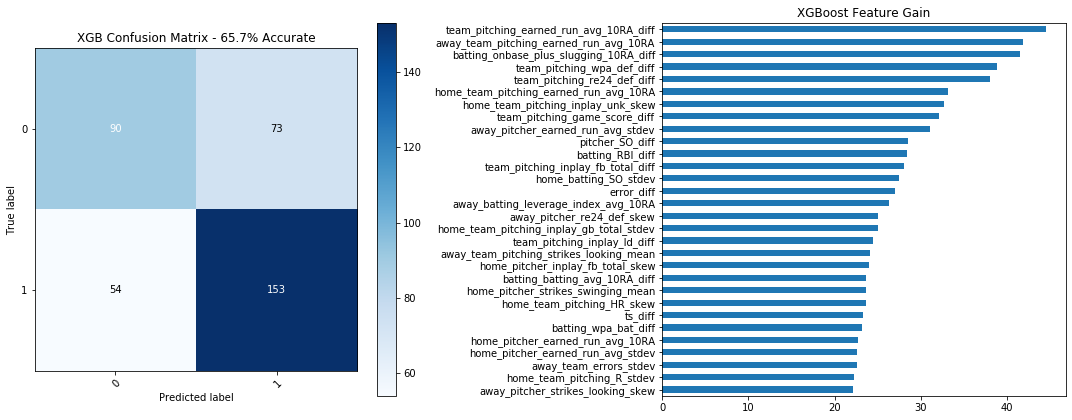

In [25]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

x = pd.Series(model.get_booster().get_score(importance_type= 'total_gain')
         ).sort_values()
x[-30:].plot(kind='barh',ax=ax[1], title="XGBoost Feature Gain")

util.plot_confusion_matrix(y_valid, xgb_test_preds, [0,1], 
                           ax=ax[0], title = f"XGB Confusion Matrix - {accuracy_score(y_valid, xgb_test_preds)*100:.1f}% Accurate")

fig.tight_layout()

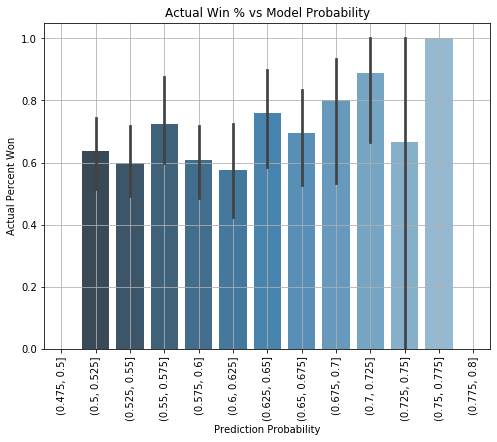

In [28]:
df = pd.DataFrame()
df['proba'] = xgb_test_proba
df['home_win'] = list(y_valid)
df['confidence'] = np.abs(df.proba-.5)+.5
df['bet_win'] = df['home_win']
df['bet_win'][df['proba']<.5] = -df['home_win']

bins=[x/40 for x in range(19,33)]
df['probability_bin'] = pd.cut(df['confidence'], bins)

plt.figure(figsize=(8,6))
ax = sns.barplot(x=df['probability_bin'], y=df.bet_win,palette="Blues_d")
ax.set_title("Actual Win % vs Model Probability")
plt.ylabel("Actual Percent Won")
plt.xlabel("Prediction Probability")
ax.grid()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

# df.groupby('probability_bin')['bet_win'].agg(['mean','count'])

In [29]:
print("win % for bets with greater than x confidence:")
for x in range(10,18):
    d = df.bet_win[df.confidence>x/20]
    print(f" conf: {x/20:.2f}, win %:{d.mean()*100:.1f}%, % of total {d.count()/6:.1f}%")

win % for bets with greater than x confidence:
 conf: 0.50, win %:65.7%, % of total 61.7%
 conf: 0.55, win %:67.9%, % of total 39.5%
 conf: 0.60, win %:69.9%, % of total 22.2%
 conf: 0.65, win %:75.0%, % of total 10.7%
 conf: 0.70, win %:84.6%, % of total 2.2%
 conf: 0.75, win %:100.0%, % of total 0.2%
 conf: 0.80, win %:nan%, % of total 0.0%
 conf: 0.85, win %:nan%, % of total 0.0%


# Other Models

## LightGBM

In [ ]:
import lightgbm as lgbm

In [ ]:
lgbm_params = {'colsample_by_tree': 0.7,
 'learning_rate': 0.65,
 'max_depth': 8,
 'min_data_in_leaf': 500,
 'num_leaves': 204,
 'subsample': 0.6,
 'boosting_type': 'gbdt'}

In [ ]:
gbm = lgbm.LGBMClassifier(**lgbm_params,num_boost_round=100, random_state=-1)
model = gbm.fit(X_train, y_train,
                verbose=False,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                early_stopping_rounds=15)
lgbm_test_preds = model.predict(X_valid)
lgbm_test_proba = model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, lgbm_test_preds), roc_auc_score(y_valid, lgbm_test_preds)

In [ ]:
def lgbm_objective(new_params, data):
    X_train,y_train,X_valid,y_valid, params = data
    
    if 'max_depth' in new_params.keys():
        new_params['max_depth']=int(new_params['max_depth'])
        params['num_leaves']=int(2**params['max_depth']*params['num_leaves'])
    if 'min_data_in_leaf' in new_params.keys():
        params['min_data_in_leaf']=int(params['min_data_in_leaf'])
    
    for x in new_params.keys():
        params[x] = new_params[x]
    
    np.random.seed(13)
    gbm = lgbm.LGBMClassifier(**params, num_boost_round=100, random_state=13)
    lgbm_model = gbm.fit(X_train, y_train,
                    verbose=False,
                    eval_set = [[X_train, y_train],
                              [X_valid, y_valid]],
                    early_stopping_rounds=15)
    lgbm_test_preds = lgbm_model.predict(X_valid)
    
    proba = lgbm_model.predict_proba(X_valid)[:,1]
    
    #penalize low discrimination
    score = -roc_auc_score(y_valid, lgbm_test_preds)
    if max(proba)<.7 and min(proba)>.3: score += 0.05
    
    return score 
def get_lgbmparams(space, full_params, evals=15):
    fmin_objective = partial(xgb_objective, data=(X_train,y_train,X_valid,y_valid,full_params))
    
    params = fmin(fmin_objective,
        space=space,
        algo=tpe.suggest,
        max_evals=evals)
    
    #update full_params
    for x in full_params.keys():
        if x in params.keys():
            full_params[x]=params[x]
    full_params['max_depth']=int(full_params['max_depth'])
    full_params['min_data_in_leaf']=int(full_params['min_data_in_leaf'])
    full_params['num_leaves']=int(2**full_params['max_depth']*full_params['num_leaves'])

    return full_params

In [ ]:
space = {
    'learning_rate': hp.quniform('learning_rate', .05, .8, .05),
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'num_leaves': hp.quniform('num_leaves', 0.5, 1.0,.1),
#     'subsample': hp.quniform('subsample', 0.05, 1, .05),
#     'colsample_bytree': hp.quniform('colsample_by_tree', 0.05, 1.0,.05),
#     'min_data_in_leaf':hp.qloguniform('min_data_in_leaf', 5, 10, 100),
}
lgbm_params = get_lgbmparams(space,lgbm_params,25)

In [ ]:
space = {
#     'learning_rate': hp.quniform('learning_rate', .05, .8, .05),
#     'max_depth': hp.quniform('max_depth', 2, 10, 1),
#     'num_leaves': hp.quniform('num_leaves', 0.5, 1.0,.1),
    'subsample': hp.quniform('subsample', 0.1, 1, .1),
    'colsample_bytree': hp.quniform('colsample_by_tree', 0.1, 1.0,.1),
    'min_data_in_leaf':hp.qloguniform('min_data_in_leaf', 5, 10, 100),
}
lgbm_params = get_lgbmparams(space,lgbm_params,25)

In [ ]:
lgbm_params

In [ ]:
np.random.seed(13)
gbm = lgbm.LGBMClassifier(**lgbm_params, num_boost_round=100, random_state=13)
lgbm_model = gbm.fit(X_train, y_train,
                verbose=True,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                early_stopping_rounds=15)
lgbm_test_preds = lgbm_model.predict(X_valid)
lgbm_test_proba = lgbm_model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, lgbm_test_preds), roc_auc_score(y_valid, lgbm_test_preds)

In [ ]:
print(f"new model ROC: {roc_auc_score(y_valid, lgbm_test_preds):.3f}\nold model ROC: {bench_roc:.3f}\n")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

lgbm_model.importance_type='gain'
l = pd.DataFrame(zip(X_train.columns,lgbm_model.feature_importances_), 
                 columns=['feature','value']).set_index('feature').sort_values(by='value')
l[-30:].plot(kind='barh',ax=ax[1],title="LightGBM Feature Gain")

util.plot_confusion_matrix(y_valid, lgbm_test_preds, [0,1], ax=ax[0],
                           title = f"LGBM Confusion Matrix - {accuracy_score(y_valid, lgbm_test_preds)*100:.1f}% Accurate")

fig.tight_layout()

In [ ]:
df = pd.DataFrame()
df['proba'] = lgbm_test_proba
df['home_win'] = list(y_valid)
df['confidence'] = np.abs(df.proba-.5)+.5
df['bet_win'] = df['home_win']
df['bet_win'][df['proba']<.5] = -df['home_win']

bins=[x/40 for x in range(19,30)]
df['probability_bin'] = pd.cut(df['confidence'], bins)

plt.figure(figsize=(8,6))
ax = sns.barplot(x=df['probability_bin'], y=df.bet_win,palette="Blues_d")
ax.set_title("Actual Win % vs Model Probability")
plt.ylabel("Actual Percent Won")
plt.xlabel("Prediction Probability")
ax.grid()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

# df.groupby('probability_bin')['bet_win'].agg(['mean','count'])

In [ ]:
print("win % for bets with greater than x confidence:")
for x in range(10,19):
    d = df.bet_win[df.confidence>x/20]
    print(f" conf: {x/20:.2f}, win %:{d.mean()*100:.1f}%, % of total {d.count()/6:.1f}%")

## Fastai

In [ ]:
from fastai import *
from fastai.tabular import *

In [ ]:
CAT_NAMES = [x for x in df.columns if df[x].dtype=='object']
CONT_NAMES = [x for x in df.columns if df[x].dtype not in ['object','bool']]

In [ ]:
data = (TabularList.from_df(df, path='.',                         
                        cat_names=CAT_NAMES,                        
                        cont_names=CONT_NAMES,                      
                        procs=[FillMissing, Categorify, Normalize]) 
        .split_by_idx(list(range(300)))                                        
        .label_from_df(cols='home_team_win')                                    
        .databunch())

In [ ]:
learn = tabular_learner(data, layers=[1000, 500], metrics=accuracy,          
                        ps=[.03, .3], wd=1e-1, emb_drop=.6)               

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
lr = learn.recorder.min_grad_lr

In [ ]:
learn.fit_one_cycle(2, max_lr=1e-6) 

In [ ]:
preds, y = learn.get_preds(ds_type=DatasetType.Valid, with_loss=False)
preds = np.array(preds)[:,1]
accuracy_score(y, preds>0.5), roc_auc_score(y, preds>0.5)

In [ ]:
from hyperopt import fmin, tpe, hp, Trials
import fastai
from fastprogress import force_console_behavior
import fastprogress

space = {'p2': hp.quniform('p2',0,.8,.1),
    'emb_drop': hp.quniform('emb_drop',0,.8,.1),
    'l1': hp.quniform('l1',500,1500,100),
         }

# suppress widgets
fastprogress.fastprogress.NO_BAR = True
master_bar, progress_bar = force_console_behavior()
fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar
fastprogress.fastprogress.WRITER_FN = str

def objective(x):
    #get params from hyperopt
    p2 = x['p2']
    p1 = p2/10
    emb_drop = x['emb_drop']
    l1=int(x['l1'])
    l2 = int(l1/2)
    # lr = x['lr']
    
    # freeze seeds
    import random
    import torch
    seed = 13
    random.seed(seed)    #python
    np.random.seed(seed) #numpy
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

    # get to work
    learn = tabular_learner(data, layers=[l1,l2],ps=[p1,p2], wd=1e-1, emb_drop=emb_drop)
    learn.fit_one_cycle(2, max_lr=1e-2)
    preds, y = learn.get_preds(ds_type=DatasetType.Valid, with_loss=False)
    preds = np.array(preds)
    score = -roc_auc_score(y, preds[:,1]>0.5)
    
    return {'loss': score, 'status':'ok'}

trials = Trials()

best = fmin(objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials)
best